# Sea Ice Concentration and Edge demonstrated on the SCEPS Polar Scene

**Authors**: T. Lavergne (METNO)

Demonstration notebook [DD-JNB] prepared for TC#2 (Technical Check Point #2)  in the CIMR L2PAD project. The notebook demonstrates applying the L2 SI Concentration and Edge algorithms on the SCEPS Polar Scene 1 simulation, after it has gone through the L1B/L2 Bridge. This notebook thus takes an L2PP (_Level-2 Pre-Processed_) file as input.

At the end of the notebook, SIC and SIED fields are written in a L2 netCDF file. These files are re-opened in a companion *Performance Assessment* notebook, in which the output of the L2 processing are compared to the reference SCEPS Polar Scene 1 maps.

This notebook is adapted from one prepared in the CIMR DEVALGO precursor project.

In [1]:
import os, sys
from importlib import reload

import xarray as xr
import numpy as np

from collections import OrderedDict

from datetime import datetime

import pyresample as pr

from matplotlib import pylab as plt
import cartopy.crs as ccrs
import cmocean
import matplotlib as mpl

import copy

import json

In [2]:
# 'local' software modules to implement the SIC algorithm
_syspath = list(sys.path)
for path in _syspath:
    if '/algorithm/' in _syspath:
        break
    else:
        sys.path.insert(0, os.path.abspath('../algorithm'))
        break

from sirrdp import rrdp_file
from pmr_sic import tiepoints as tp
from pmr_sic import hybrid_algo
from pmr_sic import algo as single_algo
from pmr_sic import common
from pansharpen import pansharpen_gridded

# 'l1bl2 bridge' software modules to read the l2pp files
_syspath = list(sys.path)
for path in _syspath:
    if '/L1BL2Bridge_ATBD/' in _syspath:
        break
    else:
        sys.path.insert(0, os.path.abspath('../../L1BL2Bridge_ATBD/algorithm'))
        break
from tools import io_handler as io
from tools import collocation as coll

# 'common' software modules to access EASE2 grid definition
sys.path.append('../../')
from common import L2Grids
from common import L2Filename
from common import L2Writer

Create a data directory to hold temporary and output files that are created by the notebook.

In [3]:
l2_dir = os.path.abspath('../data') + '/output/DD-JNB_out'
if not os.path.isdir(l2_dir):
    os.mkdir(l2_dir)

## Locate DI-TDS-JNB and configuration

The input data for this notebook are organized under [DI-TDS-JNB] (Test Data Set for Jupyter NoteBook). The default is to access this TDS online through thredds / opendap unless the environment variable `CIMR_L2PAD_JNB_TDS` is set. If it is set, it is the path to a local copy of the TDS.

We access an L2PP file with all the TBs and auxiliary fields added in the L1B/L2 Bridge, including OZA compensation terms, as well as atmospheric contribution terms tau, Tup, and Tdown (among others).

In [33]:
try:
    tds_root = os.environ["CIMR_L2PAD_JNB_TDS"]
    print("Use local TDS: {}".format(tds_root))
except KeyError:
    tds_root = 'https://thredds.met.no/thredds/dodsC/cimr/L2PAD/DI-TDS-JNB_V2D'
    print("Use online TDS: {}".format(tds_root))


Use local TDS: /home/thomasl/Work/L2PAD/local_TDS


In [5]:
l2pp_path = os.path.join(tds_root,'CIMR_L2PP','L2PAD_l2pp_sceps_geo_polar_scene_1_unfiltered_tot_minimal_nom_nedt_apc_tot_v2p1.nc')

The L2 SIC algorithm coefficients (tie-points, ice-line vector, etc...) are dynamically tuned in the offline part of the chain. The tuning results in a set of parameter files (JSON format for now) that need to be loaded before we can run the algorithm.

In [6]:
aux_dir = '../data/L2SIC_tuning/'
SIC_tuning_method = 'CIMRL1B-ALLFEEDS'

In [7]:
# summarize configuration for the run:
print("Input L2PP file: ", l2pp_path)
print("Dir for L2 SIC parameters: ", aux_dir)
print("Ouput L2 SIC+SIED dir: ", l2_dir)
#print("Target L2 grid: ", l2_grid)
#print("Use OZA adjusted TBs: ", use_oza_adjust)
print("L2 SIC tuning method: ", SIC_tuning_method)

Input L2PP file:  /home/thomasl/Work/L2PAD/local_TDS/CIMR_L2PP/L2PAD_l2pp_sceps_geo_polar_scene_1_unfiltered_tot_minimal_nom_nedt_apc_tot_v2p1.nc
Dir for L2 SIC parameters:  ../data/L2SIC_tuning/
Ouput L2 SIC+SIED dir:  /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out
L2 SIC tuning method:  CIMRL1B-ALLFEEDS


Prepare the L2 SIC algorithms, `CKA`, `KKA`, and `KA` and the TB channels that will be needed to run themm.

In [8]:
algos = OrderedDict()
algos['CKA'] = {'channels':('tb06v', 'tb37v', 'tb37h'), 'target_band':'C'}
algos['KKA'] = {'channels':('tb19v', 'tb37v', 'tb37h'), 'target_band':'KA'}
algos['KA'] = {'channels':('tb37v', 'tb37h'),  'target_band':'KA'}

channels_needed = []
for alg in algos.keys():
    channels_needed += algos[alg]['channels']
channels_needed = set(channels_needed)

tb_dict = {'tb01':'L','tb06':'C','tb10':'X','tb19':'KU','tb37':'KA',}
rev_tb_dict = {v:k for k,v in tb_dict.items()}
bands_needed = []
for alg in algos.keys():
    bands_needed += algos[alg]['channels']
bands_needed = list(set([tb_dict[b[:-1]] for b in bands_needed]))

## Load the pre-tuned CKA, KKA, and KA algorithms from parameter files

In [9]:
for alg in algos.keys():
    if SIC_tuning_method == 'CIMRL1B-PERFEED':
        algos[alg]['algo'] = []
        # load 1 tuned SIC algo per FEED (target band)
        for f in range(io.n_horns[algos[alg]['target_band']]):
            json_fn = os.path.join(aux_dir,'{}_sic_{}.json'.format(alg.upper(), 'CIMRL1B-FEED{}'.format(f)))
            print("Load tuned {} algo from {}".format(alg, json_fn))
            if not os.path.exists(json_fn):
                raise ValueError("Cannot find AUX parameter file for {} SIC:\n\t{}".format(alg, json_fn))
            with open(json_fn) as fp:
                algo_sic_params = json.load(fp)
            algo_sic_params = common.numpify(algo_sic_params)
            algos[alg]['algo'].append(hybrid_algo.HybridSICAlgo.from_dict(algo_sic_params))
    else:
        # load 1 tune SIC algo
        json_fn = os.path.join(aux_dir,'{}_sic_{}.json'.format(alg.upper(), SIC_tuning_method))
        print("Load tuned {} algo from {}".format(alg, json_fn))
        if not os.path.exists(json_fn):
            raise ValueError("Cannot find AUX parameter file for {} SIC:\n\t{}".format(alg, json_fn))
    
        with open(json_fn) as fp:
            algo_sic_params = json.load(fp)
                                    
        algo_sic_params = common.numpify(algo_sic_params)
        algos[alg]['algo'] = hybrid_algo.HybridSICAlgo.from_dict(algo_sic_params)

Load tuned CKA algo from ../data/L2SIC_tuning/CKA_sic_CIMRL1B-ALLFEEDS.json
Load tuned KKA algo from ../data/L2SIC_tuning/KKA_sic_CIMRL1B-ALLFEEDS.json
Load tuned KA algo from ../data/L2SIC_tuning/KA_sic_CIMRL1B-ALLFEEDS.json


### Step 1: Load the L2PP file and prepare remapped TB arrays for each algo

The three algorithms `CKA`, `KKA`, and `KA` combine different microwave channels (e.g. `CKA` combines C-Vpol, Ka-Vpol, and Ka-Hpol). Since each frequency channel is not sampled at the same location nor resolution, we must prepare location-matched, resolution-matched TB arrays for each algorithm.

In this version of the algorithm, we prepare TB arrays at the spatial resolution of the coarsest channel (e.g. we prepare C-Vpol, Ka-Vpol, and Ka-Hpol to the resolution of C-Vpol as input to the `CKA` algorithm).

We also split the L2PP TB array in a _for_ and an _aft_ TB arrays.

We handle the collocation differently for the 3 algorithms:
* `CKA` mixes TBs from different feeds, and we use a nearest-neighbour resampling;
* `KKA` and `KA` use TBs from the same (dual freq.) feeds, and we use the along-arc resampling.

This remapping is at the moment handled by own software, while the CIMR RGB will be used in the longer run.

In [10]:
# read L2PP file. We only read the bands needed for the three algorithms
reload(io)
full_l2pp = io.CIMR_L1B(l2pp_path, selected_bands=bands_needed, keep_calibration_view=True,)

print("Original list of all variables per band:", list(full_l2pp.data['C'].variables))

Original list of all variables per band: ['time_earth', 'lon', 'lat', 'alt', 'OZA', 'scan_angle', 'scan_angle_feeds_offsets_relative_to_reflector', 'instrument_status', 'sub_satellite_lat', 'sub_satellite_lon', 'satellite_position', 'satellite_velocity', 'Reflector2EarthCenteredInertialFrame', 'Reflector2SatelliteBodyFrame', 'Reflector2NavigationFrame', 'Navigation2EarthCenteredInertialFrame', 'SatelliteBody2EarthCenteredInertialFrame', 'SatelliteBody2EarthCenteredInertialFrameUsingBodyFrameCFI', 'ant_physical_temp_h', 'ant_physical_temp_v', 'reflector_temp_h', 'reflector_temp_v', 'feed_temp_h', 'feed_temp_v', 'wf_temp_h', 'wf_temp_v', 'switch_assembly_temp_h', 'switch_assembly_temp_v', 'brightness_temperature_h', 'brightness_temperature_v', 'brightness_temperature_t3', 'brightness_temperature_t4', 'apc_hv_hbs', 'apc_hv_ext', 'receiver_temperature_h', 'receiver_temperature_v', 'receiver_temperature_t3', 'receiver_temperature_t4', 'x_h', 'x_v', 'acl_sky_h', 'acl_sky_v', 'satellite_groun

The L2PP files contain a lot of variables that we are not going to use in the SIC nor SIED algorithms. We keep only the variables we will need.

In [11]:
aux_vars = ('lon', 'lat', 'OZA', 'earth_azimuth',
             'scan_angle', 'horn_scan_angle', 'time_earth')
l2pp_vars = ('orig_scan', 'orig_sample', 'orig_horn','brightness_temperature_h', 'brightness_temperature_v',
             'oza_compens_RTM_brightness_temperature_v', 'oza_compens_RTM_brightness_temperature_h',
             'fastL2_ice_cover',
             'trans_at_oza_ref_for_actual_atm', 'trans_at_oza_ref_for_reference_atm',
             'tb_up_at_oza_ref_for_actual_atm', 'tb_up_at_oza_ref_for_reference_atm',
             'tb_dn_at_oza_ref_for_actual_atm', 'tb_dn_at_oza_ref_for_reference_atm')

keep_vars = tuple(list(aux_vars) + list(l2pp_vars))

drop_vars = []
for v in full_l2pp.data[bands_needed[0]].variables:
    if v not in keep_vars:
        drop_vars.append(v)

for band in bands_needed:
    full_l2pp.data[band] = full_l2pp.data[band].drop_vars(drop_vars, )

print("Reduced list of variables per band:\n", '\n'.join(list(full_l2pp.data['C'].variables)))

Reduced list of variables per band:
 time_earth
lon
lat
OZA
scan_angle
brightness_temperature_h
brightness_temperature_v
earth_azimuth
oza_compens_RTM_brightness_temperature_v
oza_compens_RTM_brightness_temperature_h
fastL2_ice_cover
trans_at_oza_ref_for_actual_atm
trans_at_oza_ref_for_reference_atm
tb_up_at_oza_ref_for_actual_atm
tb_up_at_oza_ref_for_reference_atm
tb_dn_at_oza_ref_for_actual_atm
tb_dn_at_oza_ref_for_reference_atm
orig_scan
orig_sample
orig_horn
horn_scan_angle


First, we apply the annotated OZA-compensation terms that are present in the L2PP files. These terms are computed in the L2PAD L1B/L2 Bridge repository. After this, the TBs stored in the l2pp object will be compensated for the OZA effects of the surface and atmosphere.

In [12]:
full_l2pp.apply_OZA_adjustment()

Then, we do the channel remapping and resampling (this step will in the future be handled by calls to the CIMR RGB).

In [13]:
# align scanlines using the scan angle offset
full_l2pp.align_arrays_to_start_at_zero_scan_angle()

# coarsen TB samples along the scanlines with a kernel of 5 (feeds are *not* combined)
ker = 5
coarsen_l2pp = full_l2pp.coarsen_along_scanlines(kernel=ker)

# split into fore / aft scan
for_l2pp, aft_l2pp = coarsen_l2pp.split_forward_backward_scans(method='horn_scan_angle')

reload(coll)

# Collocate the channels. This step covers both the
#   definition of the target grid, and the remapping.
# We use the correct 'target_band' for
#   each algorithm.
#
# The collocation strategy differs for the algos:
#    * CKA -> NN resampling to C
#    * KKA -> along_arc
for_l2ppx = dict()
aft_l2ppx = dict()
for alg in algos.keys():
    print("Perform TB remapping for {}".format(alg,))
    if alg == 'KKA' or alg == 'KA':
        # along-arc resampling.
        _for_l2ppx = coll.collocate_channels_alongarc(for_l2pp.data, algos[alg]['target_band'], what=l2pp_vars)
        _aft_l2ppx = coll.collocate_channels_alongarc(aft_l2pp.data, algos[alg]['target_band'], what=l2pp_vars)
        # reshape by interleaving the feeds 
        for_l2ppx[alg] = coll.reshape_l1x_byinterleave(_for_l2ppx, view='forward')
        aft_l2ppx[alg] = coll.reshape_l1x_byinterleave(_aft_l2ppx, view='backward')
    else:
        # CKA: first transform 3D arrays (scan, sample, feed) into 2D (scan_interleave_feed, sample), then
        #    NN resampling.
        reshaped_for_l2pp = for_l2pp.reshape_interleave_feed()
        reshaped_aft_l2pp = aft_l2pp.reshape_interleave_feed()
        for_l2ppx[alg] = coll.collocate_channels(reshaped_for_l2pp.data, algos[alg]['target_band'], method='nn', what=l2pp_vars)
        aft_l2ppx[alg] = coll.collocate_channels(reshaped_aft_l2pp.data, algos[alg]['target_band'], method='nn', what=l2pp_vars)

Perform TB remapping for CKA


/home/thomasl/Work/L2PAD/L1BL2Bridge_ATBD/algorithm/tools/collocation.py:146: RuntimeWarning: invalid value encountered in cast
  coll_dict[w] = coll_dict[w].astype(dtypes[w])


Perform TB remapping for KKA


/home/thomasl/Work/L2PAD/L1BL2Bridge_ATBD/algorithm/tools/collocation.py:237: RuntimeWarning: invalid value encountered in cast
  coll_dict[w] = coll_dict[w].astype(l1b_data[band][w].dtype)


Perform TB remapping for KA


### Step 2: Apply the 3 algos to compute intermediate SICs

This applies the three algorithms on their respective TB arrays (obtained from the remapping of the L2PP TBs). The SIC algorithms are applied separately for the fore and aft scan of the swath.

First, we restructure the TB arrays into data structures that the SIC algorithm software can ingest.

In [14]:
# prepare TBs in the structure expected as input to the algorithm
for_tbs = dict()
aft_tbs = dict()
for alg in algos.keys():
    for_tbs[alg] = dict()
    aft_tbs[alg] = dict()
    for ch in algos[alg]['channels']:
        band = tb_dict[ch[:-1]] + '_BAND'
        varn = 'brightness_temperature_'+ch[-1]
        for_tbs[alg][ch] = for_l2ppx[alg][band][varn].values
        aft_tbs[alg][ch] = aft_l2ppx[alg][band][varn].values
            
# extract the lat/lon arrays for later use in the pan-sharpening
for_geo = dict()
aft_geo = dict()
for alg in algos.keys():
    for_geo[alg] = dict()
    aft_geo[alg] = dict()
    for ll in ('lat','lon',):
        for_geo[alg][ll] = for_l2ppx[alg]['geolocation'][ll].to_numpy()
        aft_geo[alg][ll] = aft_l2ppx[alg]['geolocation'][ll].to_numpy()
        
# extract the orig_horn arrays (for the target band)
for_feed = dict()
aft_feed = dict()
for alg in algos.keys():
    for_feed[alg] = for_l2ppx[alg][algos[alg]['target_band']+'_BAND'].orig_horn.to_numpy()
    aft_feed[alg] = aft_l2ppx[alg][algos[alg]['target_band']+'_BAND'].orig_horn.to_numpy()

Then we can apply the algorithms, and plot their resulting fields.

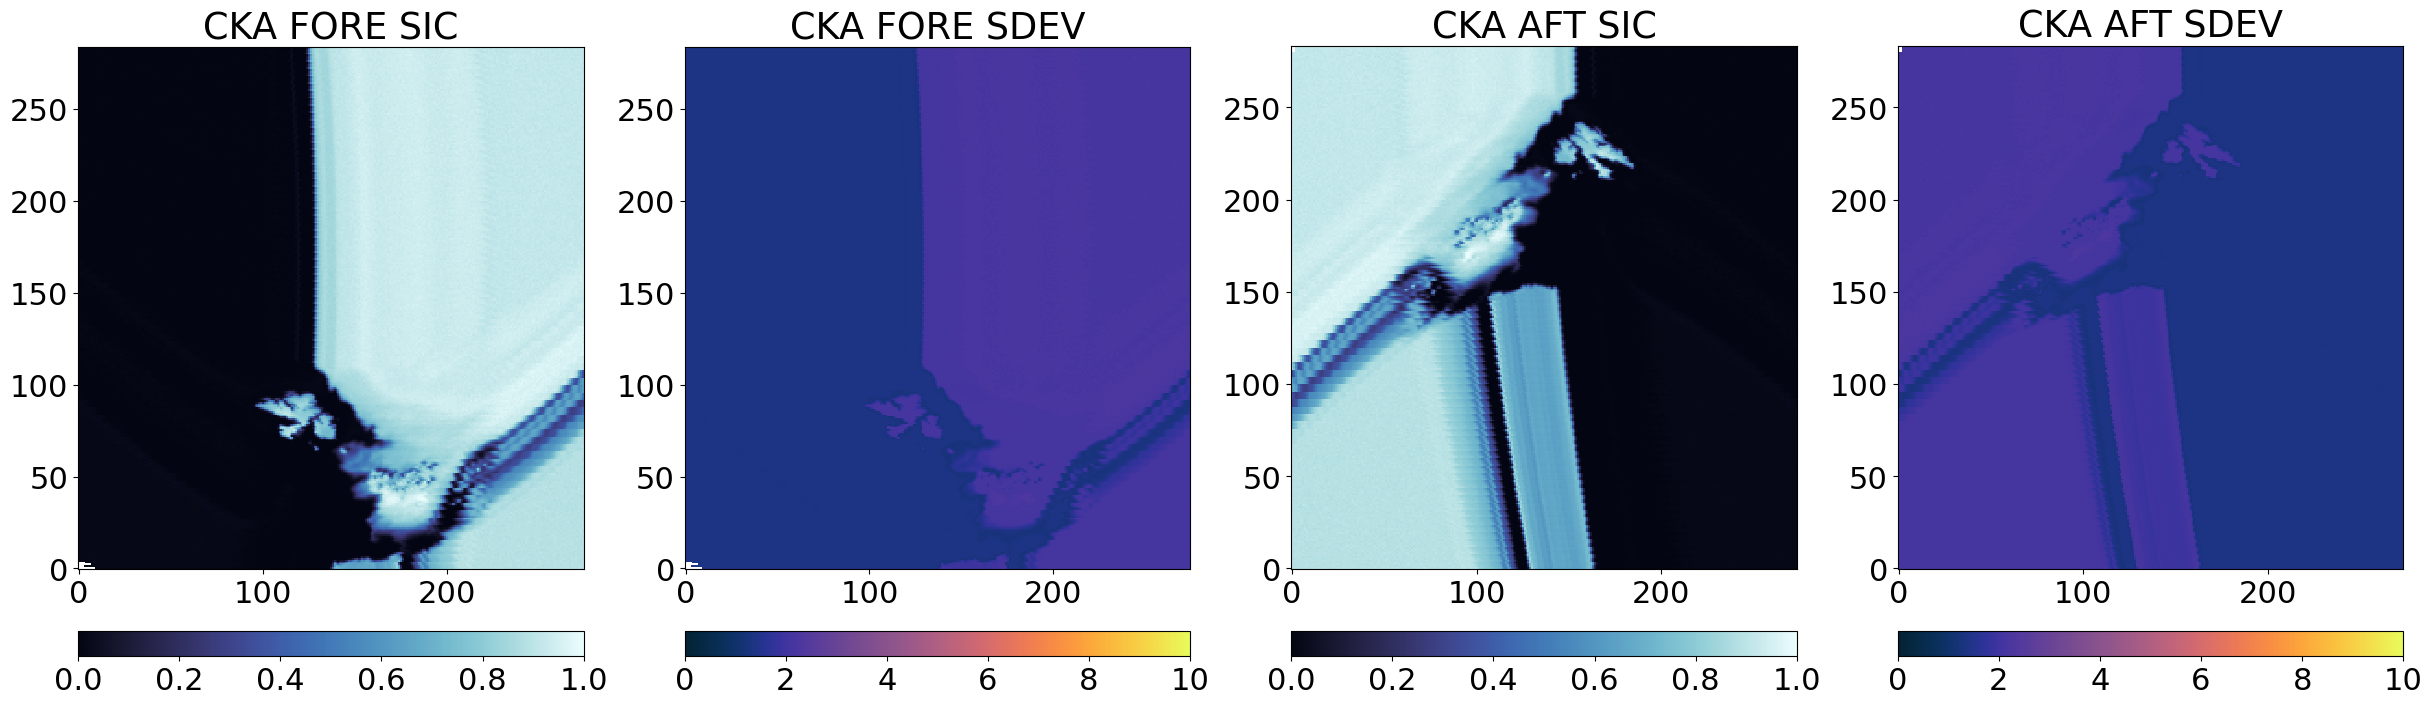

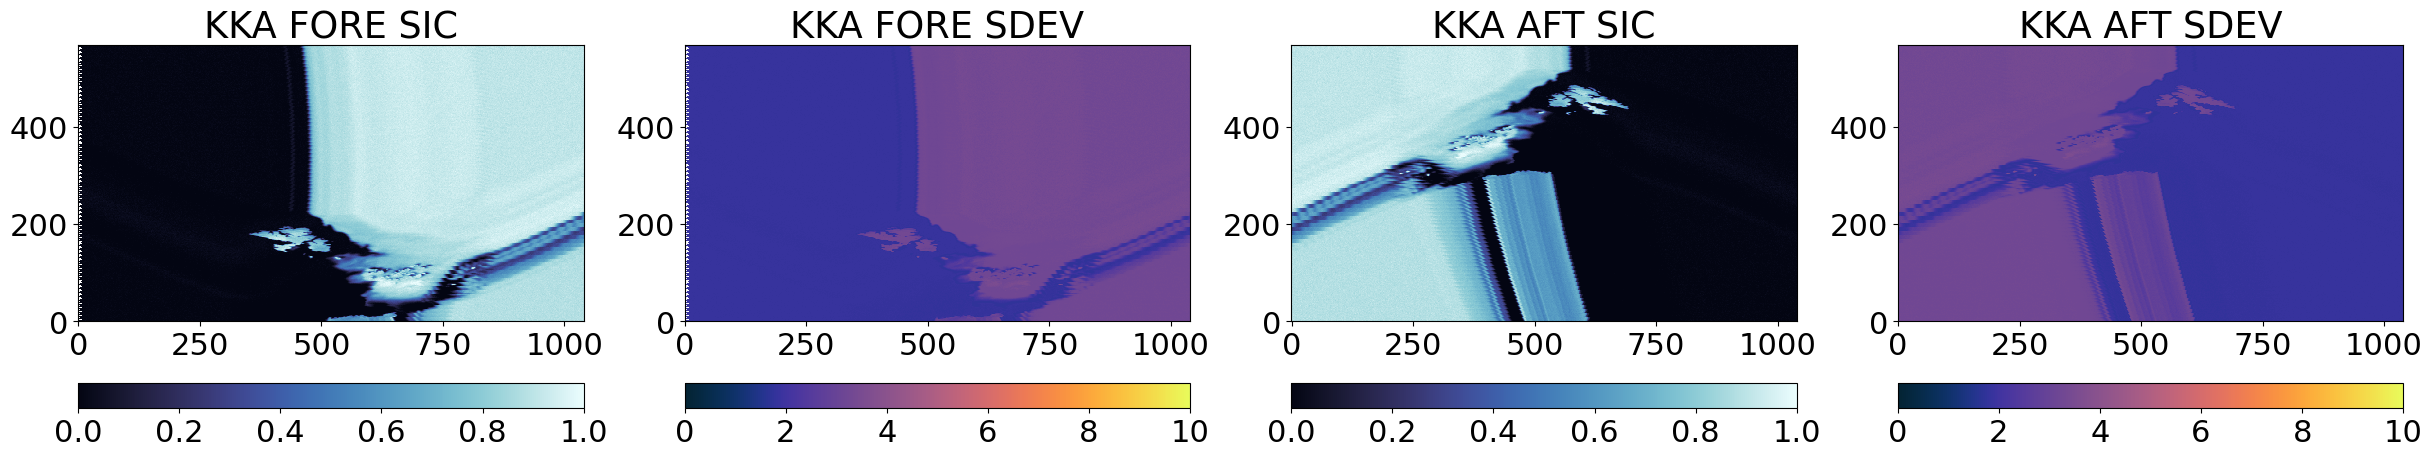

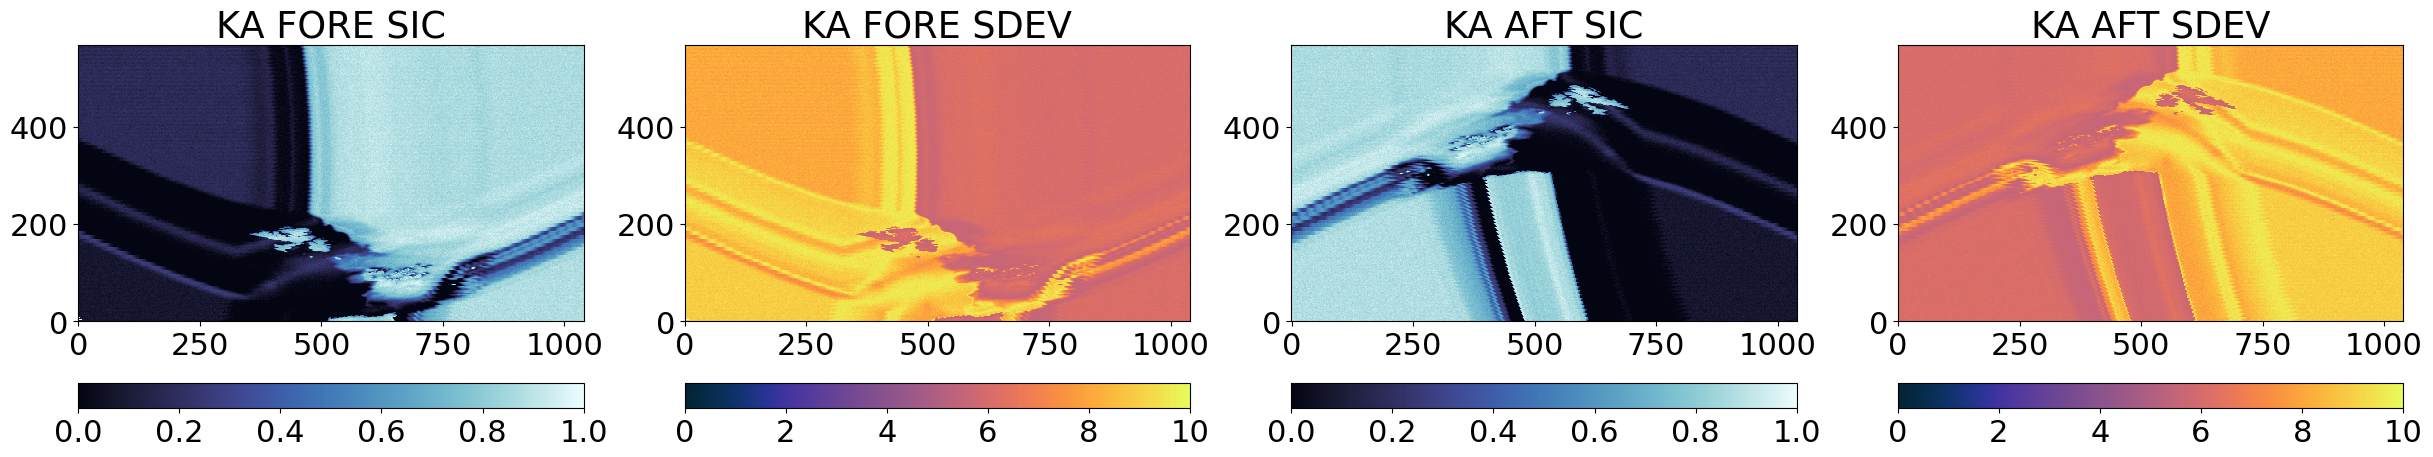

In [15]:
for_res = dict()
aft_res = dict()
for alg in algos.keys():
    
    # run the algorithm to compute SIC
    if SIC_tuning_method == 'CIMRL1B-PERFEED':
        # Run Nfeed algorithms, each on its feed scanlines, then reconstruct the 2D field
        
        # prepare the 2D result fields (filled with nans)
        _ch0 = algos[alg]['channels'][0]
        _for_sic = np.ones_like(for_tbs[alg][_ch0]) * np.nan
        _for_sdev = np.ones_like(for_tbs[alg][_ch0]) * np.nan
        _for_dal = np.ones_like(for_tbs[alg][_ch0]) * np.nan
        _for_owf = np.ones_like(for_tbs[alg][_ch0]).astype('int16') * -1
        _aft_sic = np.ones_like(aft_tbs[alg][_ch0]) * np.nan
        _aft_sdev = np.ones_like(aft_tbs[alg][_ch0]) * np.nan
        _aft_dal = np.ones_like(aft_tbs[alg][_ch0]) * np.nan
        _aft_owf = np.ones_like(aft_tbs[alg][_ch0]).astype('int16') * -1
        for f in range(io.n_horns[algos[alg]['target_band']]):
            # prepare TBs with nans everywhere expect for the current feed
            _for_tbs = deepcopy(for_tbs[alg])
            _aft_tbs = deepcopy(aft_tbs[alg])
            for ch in algos[alg]['channels']:
                _for_tbs[ch][for_feed[alg]!=f] = np.nan
                _aft_tbs[ch][aft_feed[alg]!=f] = np.nan
            # run the feed-specific algorithm 
            _for_sicf, _for_sdevf, _for_dalf, _for_owff = algos[alg]['algo'][f].compute_sic(_for_tbs)
            _aft_sicf, _aft_sdevf, _aft_dalf, _aft_owff = algos[alg]['algo'][f].compute_sic(_aft_tbs)
            # place the results into the 2D fields
            _for_sic[for_feed[alg]==f] = _for_sicf[for_feed[alg]==f]
            _for_sdev[for_feed[alg]==f] = _for_sdevf[for_feed[alg]==f]
            _for_dal[for_feed[alg]==f] = _for_dalf[for_feed[alg]==f]
            _for_owf[for_feed[alg]==f] = _for_owff[for_feed[alg]==f]
            _aft_sic[aft_feed[alg]==f] = _aft_sicf[aft_feed[alg]==f]
            _aft_sdev[aft_feed[alg]==f] = _aft_sdevf[aft_feed[alg]==f]
            _aft_dal[aft_feed[alg]==f] = _aft_dalf[aft_feed[alg]==f]
            _aft_owf[aft_feed[alg]==f] = _aft_owff[aft_feed[alg]==f]
        # store these results in a SICAlgoResults object
        for_res[alg] = sic_algo.SICAlgoResult(_for_sic, _for_sdev, _for_dal, _for_owf)
        aft_res[alg] = sic_algo.SICAlgoResult(_aft_sic, _aft_sdev, _aft_dal, _aft_owf)
        
    else:
        # Run the algorithm on the 2D fields directly
        for_res[alg] = algos[alg]['algo'].compute_sic(for_tbs[alg])
        aft_res[alg] = algos[alg]['algo'].compute_sic(aft_tbs[alg])
    
    # Simple visualization in swath L1X geometry
    cmap = cmocean.cm.ice
    ucmap = cmocean.cm.thermal
    vmin, vmax = (0, 1)
    umin, umax = (0, 10)
    
    fig = plt.figure(figsize=(30,16))
    axF = fig.add_subplot(1,4,1)
    cF = axF.imshow(for_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axF.set_title(alg + " " + "FORE" + " " + "SIC")
    plt.colorbar(cF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,2, sharex=axF, sharey=axF)
    uF = ax.imshow(for_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "FORE" + " " + "SDEV")
    plt.colorbar(uF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    axB = fig.add_subplot(1,4,3)
    cB = axB.imshow(aft_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axB.set_title(alg + " " + "AFT" + " " + "SIC")
    plt.colorbar(cB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,4, sharex=axB, sharey=axB)
    uB=ax.imshow(aft_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "AFT" + " " + "SDEV")
    plt.colorbar(uB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])

From the images above, it is clear that the three algorithms see high and low concentrations at the same locations in the Test Card, which means they are returning related SIC fields that we can combine in the next steps. The uncertainties (SDEV) are as expected lower for `CKA` than for `KKA`, and those are lower than those of `KA`.

### Step 3 : Pan-sharpening and computation of "final" Level-2 SIC

The third step deploys a pan-sharpening methodology to combine pairs of intermediate SICs into the final Level-2 SICs. In our case, the ‘base’ image can be the high-accuracy / coarse-resolution intermediate SIC from `CKA` and the ‘sharpener’ image can be the low-accuracy / fine-resolution intermediate SIC from `KA`. This results in a final SIC named `CKA@KA`.

The ATBD calls for more such pan-sharpening to happen, but for the time being we focus on `CKA@KA`.

The pansharpening equation is simply
$$
\begin{array}{lcc}
C_{ER} &=& \textrm{Remap}_{HR}(C_{LR}) +  \Delta_{edges} \\
       &=& \textrm{Remap}_{HR}(C_{LR}) + ( C_{HR} - C_{HR, blurred} ) \\ 
\end{array}
$$

where suffix "ER" refers to enhanced resolution (the final SIC), "LR" to "low resolution" (the 'base' SIC to be pan-sharpened),
and "HR" to "high resolution" (the 'sharpener' SIC). The equation also involves $C_{HR, blurred}$ which is C_{HR} blurred to
the spatial resolution of $C_{LR}$. The quantity $( C_{HR} - C_{HR, blurred})$ is sometimes referred to as a $\Delta_{edges}$ as it takes
small values everywhere but in the regions where $C_{HR}$ exhibits sharp gradients (e.g. in the Marginal Ice Zone). The $\textrm{Remap}_{HR}$ operator
remaps the location (only the location, not the resolution) of $C_{LR}$ to those of $C_{HR}$ to enable adding the two fields together. The resulting SIC field, $C_{ER}$ is
thus at the locations of $C_{HR}$, with the spatial resolution of $C_{HR}$ and the accuracy of $C_{LR}$ (if the pan-sharpening works perfectly).

There are thus 3 steps for building the pan-sharpened SIC $C_{ER}$:
1. Regrid 'base' SIC (coarse resolution) to 'sharpener' SIC (high resolution) grid
2. Prepare the 'blurred' sharpener SIC field
3. Compute $\Delta_{edges}$ and finally $C_{ER}$

We implement all these steps in the notebook to demonstrate the intermediate results. They can later be implemented in a python module for ingestion in the L2 prototype processor.

In [16]:
algo = 'CKA@KA'
base, sharpener = algo.split('@')

#### Step 3.1 Regrid 'base' SIC (coarse resolution) to 'sharpener' SIC (high resolution) grid 
A first intermediate step is to have the base SIC field (e.g. `CKA`) on the same grid as the sharpener grid `KA`. For this we use some of our collocation tools in the toolbox. 

In [17]:
# extract target and source geometries
for_trg_lon = for_geo[sharpener]['lon']
for_trg_lat = for_geo[sharpener]['lat']
for_src_lon = for_geo[base]['lon']
for_src_lat = for_geo[base]['lat']
aft_trg_lon = aft_geo[sharpener]['lon']
aft_trg_lat = aft_geo[sharpener]['lat']
aft_src_lon = aft_geo[base]['lon']
aft_src_lat = aft_geo[base]['lat']

# Prepare a stack of the data to be regridded (e.g. SIC and SDEV)
what = ('sic','sdev','dal','owf')
for_stack_shape = tuple(list(for_src_lat.shape) + [len(what),])
aft_stack_shape = tuple(list(aft_src_lat.shape) + [len(what),])
for_src_stack = np.empty(for_stack_shape)
aft_src_stack = np.empty(aft_stack_shape)
for iw, w in enumerate(what):
    for_src_stack[...,iw] = for_res[base].get(w)
    aft_src_stack[...,iw] = aft_res[base].get(w)

# regrid and get _bAs (base @ sharpener grid), 
_for_bAs = coll._regrid_fields(for_trg_lon, for_trg_lat, for_src_lon, for_src_lat, for_src_stack)
_aft_bAs = coll._regrid_fields(aft_trg_lon, aft_trg_lat, aft_src_lon, aft_src_lat, aft_src_stack)

# store in an object
for_res[algo + '(bAs)'] = single_algo.SICAlgoResult(_for_bAs[...,0], _for_bAs[...,1], _for_bAs[...,2], _for_bAs[...,3])
aft_res[algo + '(bAs)'] = single_algo.SICAlgoResult(_aft_bAs[...,0], _aft_bAs[...,1], _aft_bAs[...,2], _aft_bAs[...,3])

# The bAs now has the same shape as the sharpener
assert(for_res[sharpener].sic.shape == for_res[algo+'(bAs)'].sic.shape)
assert(aft_res[sharpener].sic.shape == aft_res[algo+'(bAs)'].sic.shape)

#### Step 3.2 Prepare the 'blurred' sharpener SIC field 

Second intermediate step is to prepare a blurred version of the sharpener SIC field, keeping it in its own grid (each grid point in the blurred SIC field is computed from the surrounding pixels in the field). The aim is to blur the 'sharpener' SIC to a resolution similar to that of the 'base' SIC (but to keep it in the 'sharpener' grid).

In [18]:
# extract target and source geometries (the same: we stay in the sharpener's grid)
for_trg_lon = for_geo[sharpener]['lon']
for_trg_lat = for_geo[sharpener]['lat']
for_src_lon = for_geo[sharpener]['lon']
for_src_lat = for_geo[sharpener]['lat']
aft_trg_lon = aft_geo[sharpener]['lon']
aft_trg_lat = aft_geo[sharpener]['lat']
aft_src_lon = aft_geo[sharpener]['lon']
aft_src_lat = aft_geo[sharpener]['lat']
# Prepare a stack of the data to be regridded (only the SIC)
what = ('sic',)
for_stack_shape = tuple(list(for_src_lat.shape) + [len(what),])
aft_stack_shape = tuple(list(aft_src_lat.shape) + [len(what),])
for_src_stack = np.empty(for_stack_shape)
aft_src_stack = np.empty(aft_stack_shape)
for iw, w in enumerate(what):
    for_src_stack[...,iw] = for_res[sharpener].get(w)
    aft_src_stack[...,iw] = aft_res[sharpener].get(w)

# regrid and get _sbl (sharpener blurred)
params = {'method':'gauss', 'sigmas':25000, 'neighbours':55}
_for_sbl = coll._regrid_fields(for_trg_lon, for_trg_lat, for_src_lon, for_src_lat, for_src_stack, params=params)
_aft_sbl = coll._regrid_fields(aft_trg_lon, aft_trg_lat, aft_src_lon, aft_src_lat, aft_src_stack, params=params)

# store in an object
for_res[algo + '(blur)'] = single_algo.SICAlgoResult(_for_sbl[...,0], for_res[sharpener].sdev, for_res[sharpener].dal, for_res[sharpener].owf)
aft_res[algo + '(blur)'] = single_algo.SICAlgoResult(_aft_sbl[...,0], aft_res[sharpener].sdev, aft_res[sharpener].dal, aft_res[sharpener].owf)

/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 55 neighbours within 62500.0 m for some data points
  get_neighbour_info(source_geo_def,


#### Step 3.3 Compute $\Delta_{edges}$ and finally $C_{ER}$

The final step of the pan-sharpening. We first compute $\Delta_{edges} = C_{HR} - C_{HR, blurred}$, then the final enhanced-resolution SIC $C_{ER}$. The later is on the grid of the sharpener.

In [19]:
# compute the delta edges
_for_delta = for_res[sharpener].sic - for_res[algo + '(blur)'].sic
_aft_delta = aft_res[sharpener].sic - aft_res[algo + '(blur)'].sic

# store in an object (intermediate result, we store it only for visualization in the notebook)
_for_zeros = np.zeros_like(_for_delta)
_aft_zeros = np.zeros_like(_aft_delta)
for_res[algo + '(delta)'] = single_algo.SICAlgoResult(_for_delta, _for_zeros, _for_zeros, _for_zeros)
aft_res[algo + '(delta)'] = single_algo.SICAlgoResult(_aft_delta, _aft_zeros, _aft_zeros, _aft_zeros)

In [20]:
# compute final pan-sharpened SIC
_for_er = for_res[algo+'(bAs)'].sic + _for_delta
_aft_er = aft_res[algo+'(bAs)'].sic + _aft_delta

# store in an object
_for_zeros = np.zeros_like(_for_delta)
_aft_zeros = np.zeros_like(_aft_delta)
for_res[algo] = single_algo.SICAlgoResult(_for_er, for_res[algo+'(bAs)'].sdev, _for_zeros, for_res[algo+'(bAs)'].owf)
aft_res[algo] = single_algo.SICAlgoResult(_aft_er, aft_res[algo+'(bAs)'].sdev, _aft_zeros, aft_res[algo+'(bAs)'].owf)

Simple visualization in swath geometry.

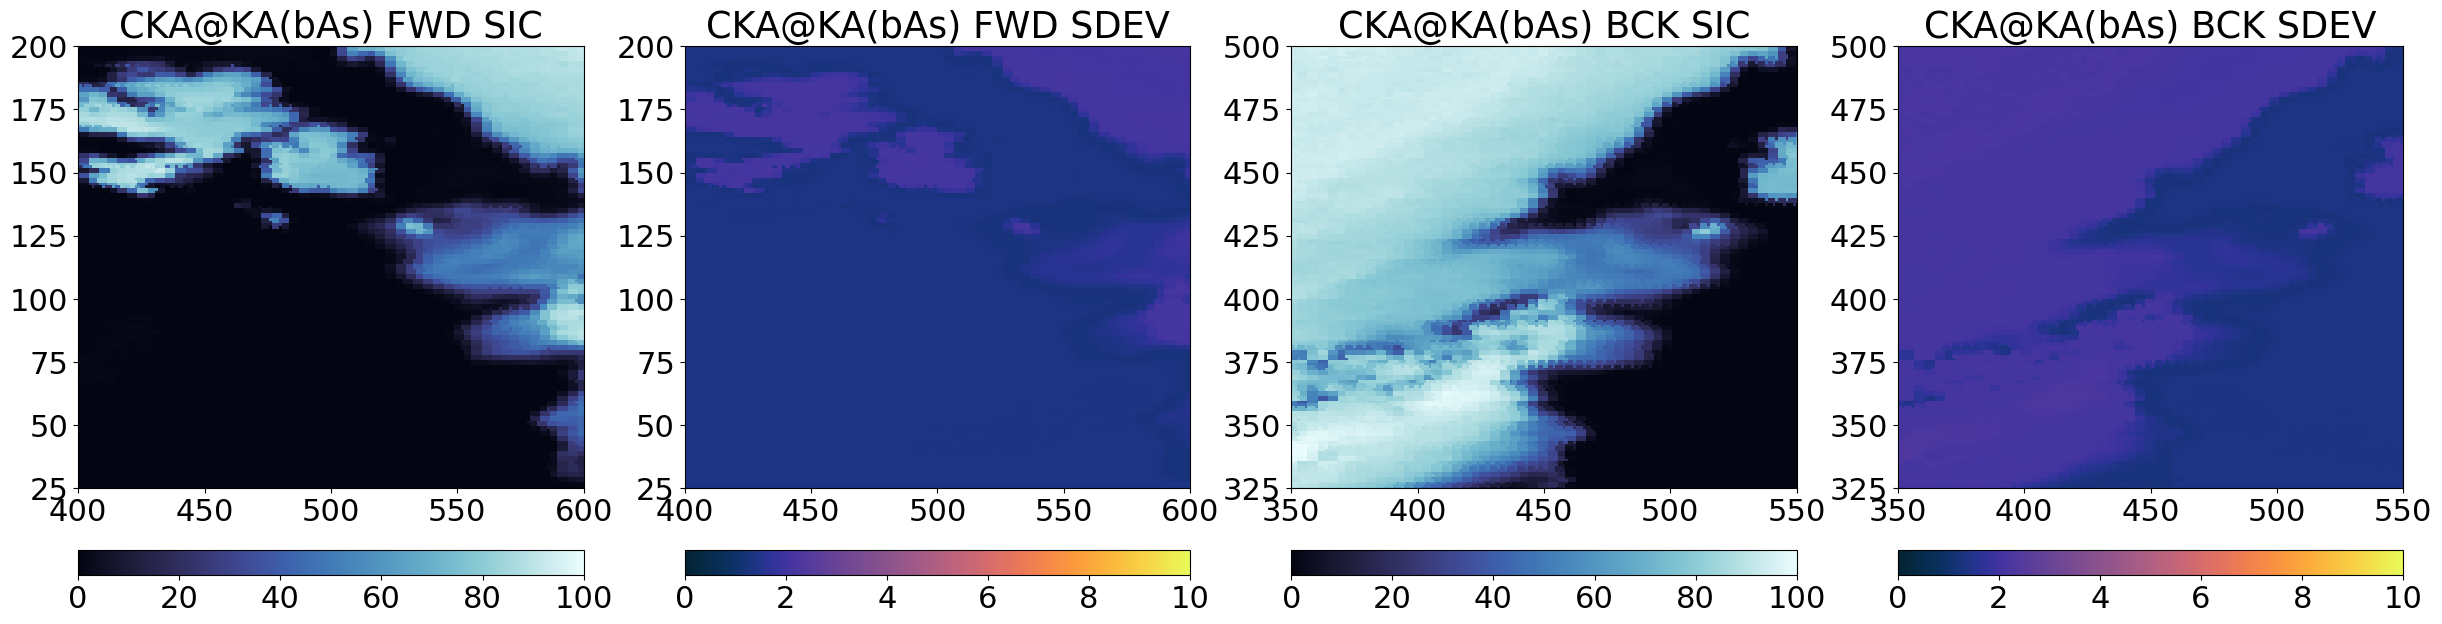

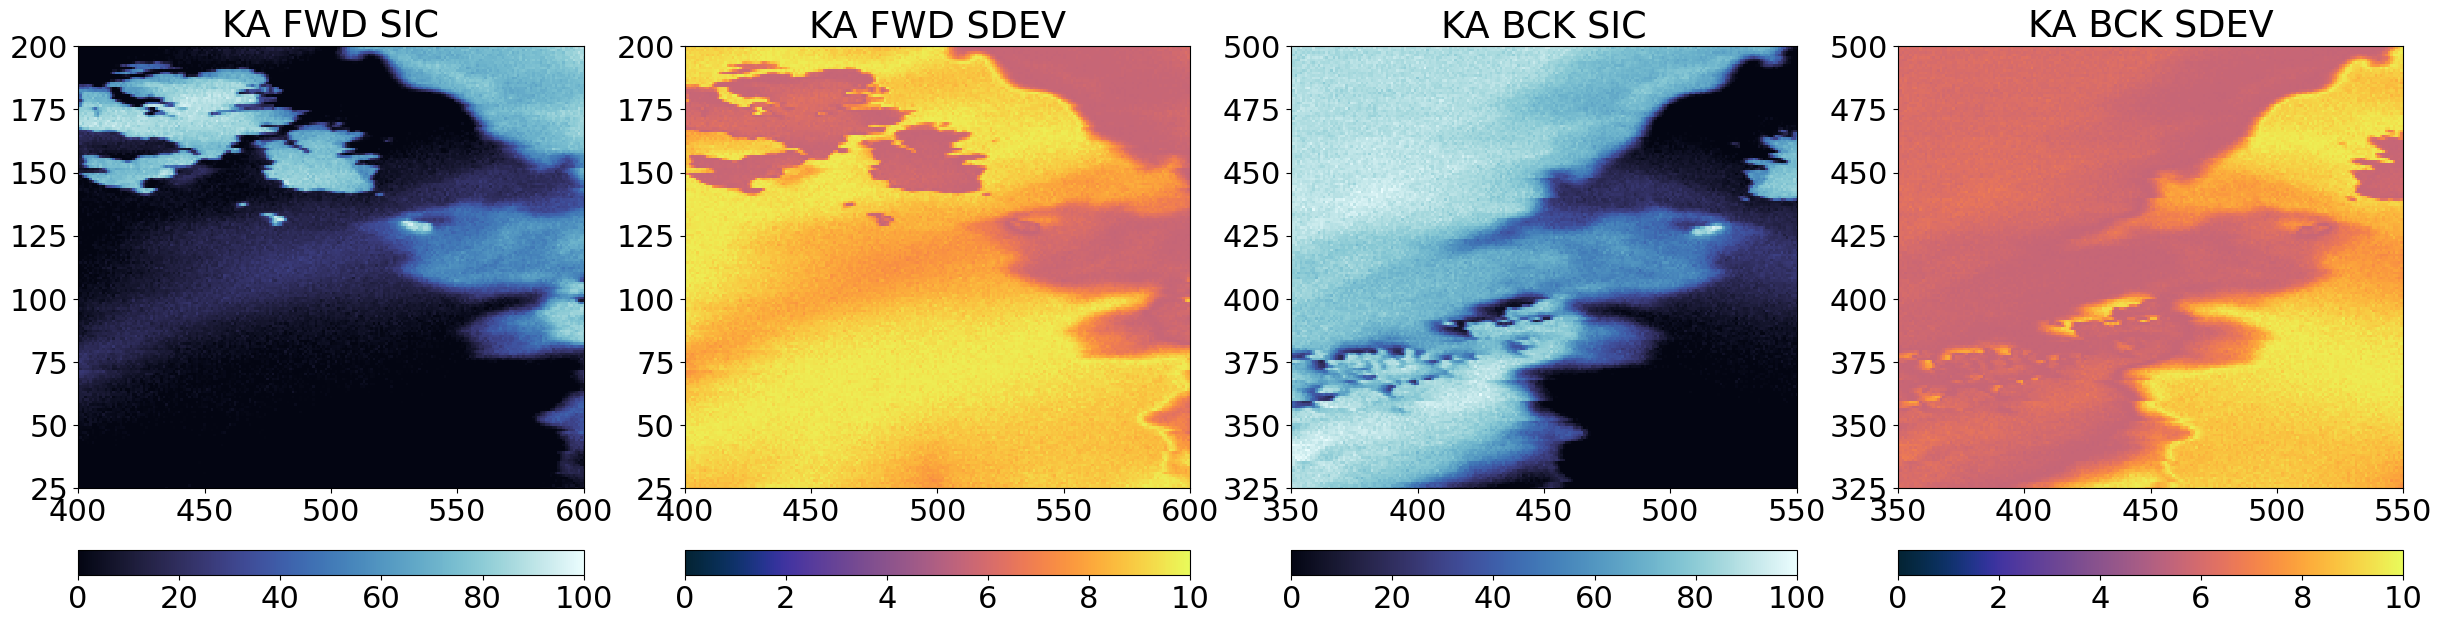

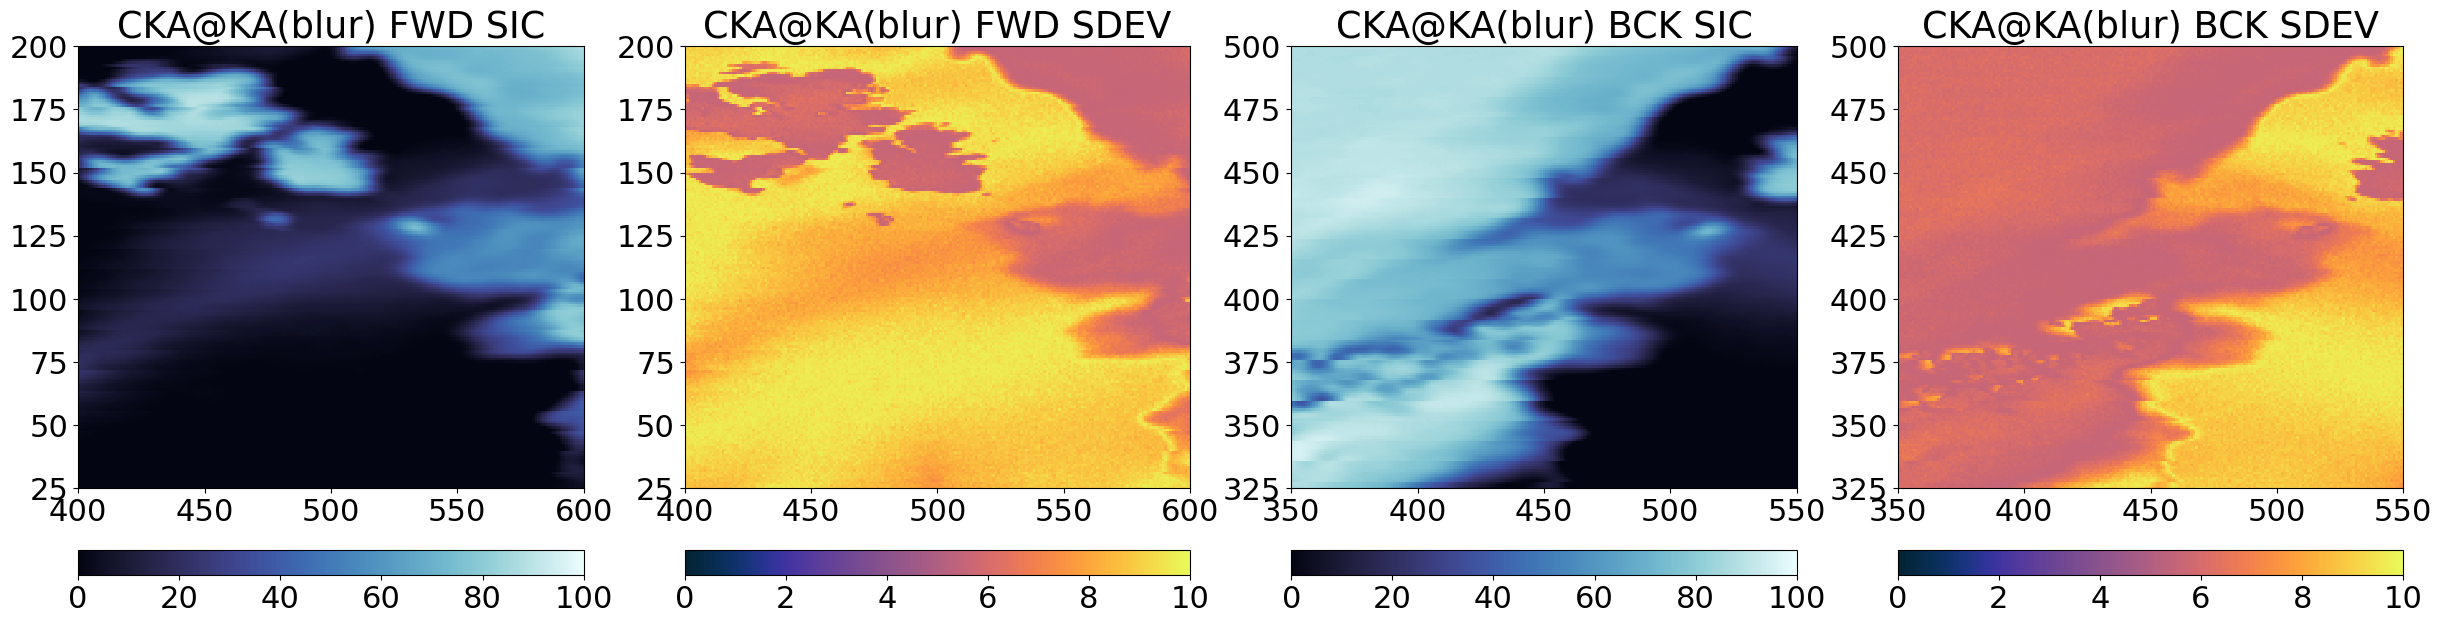

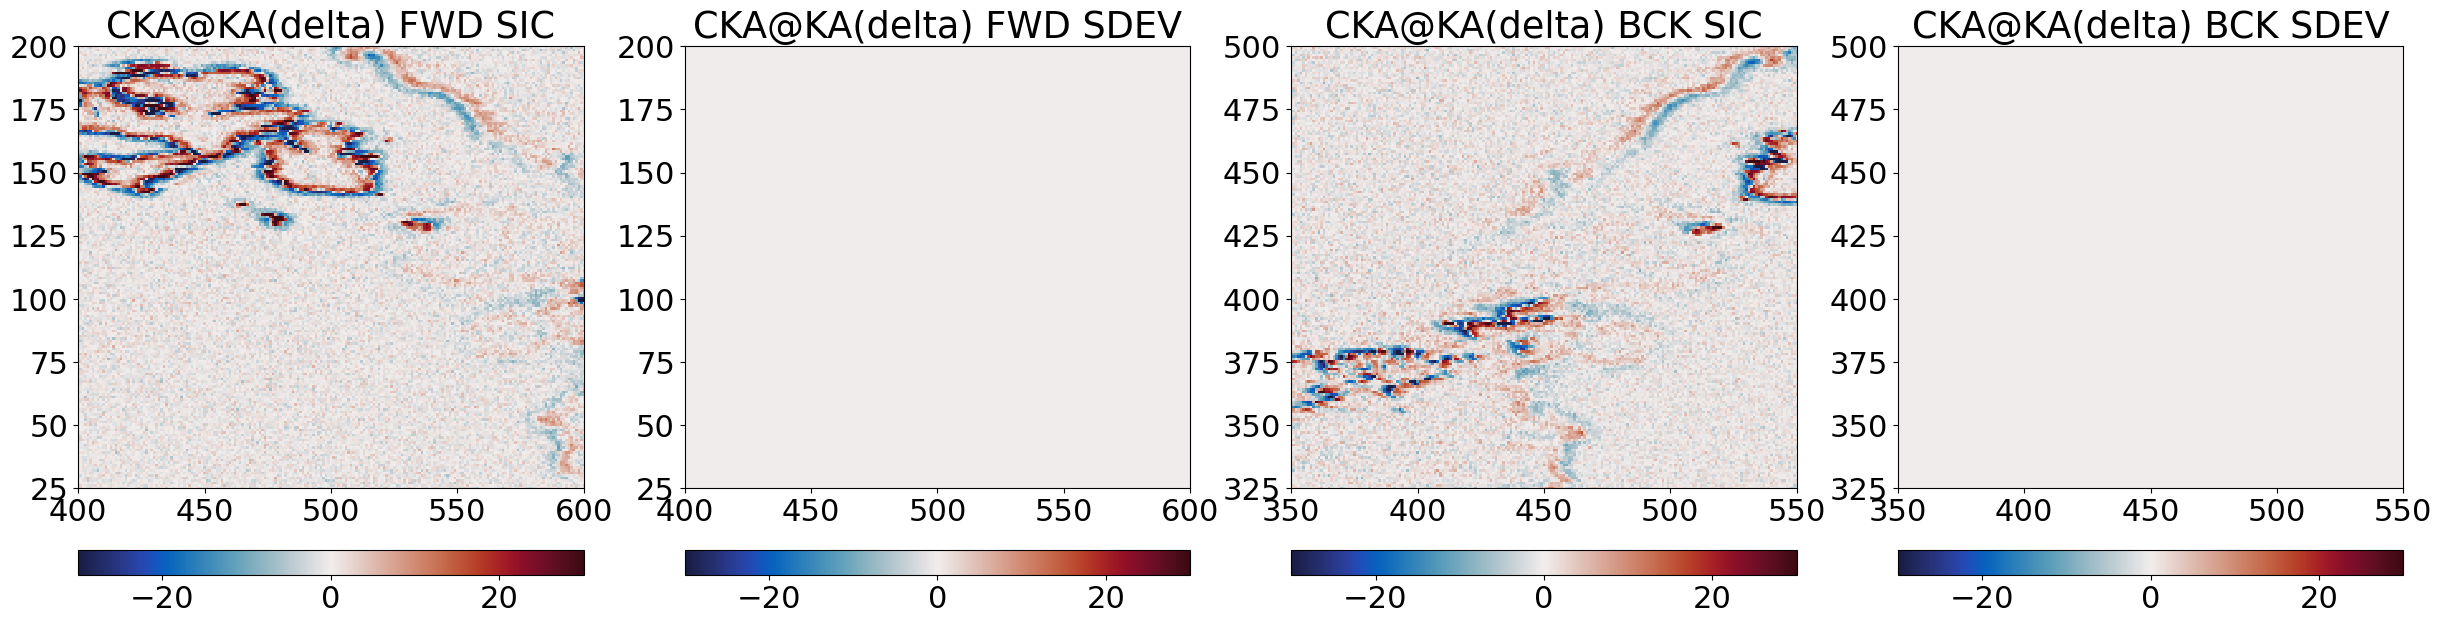

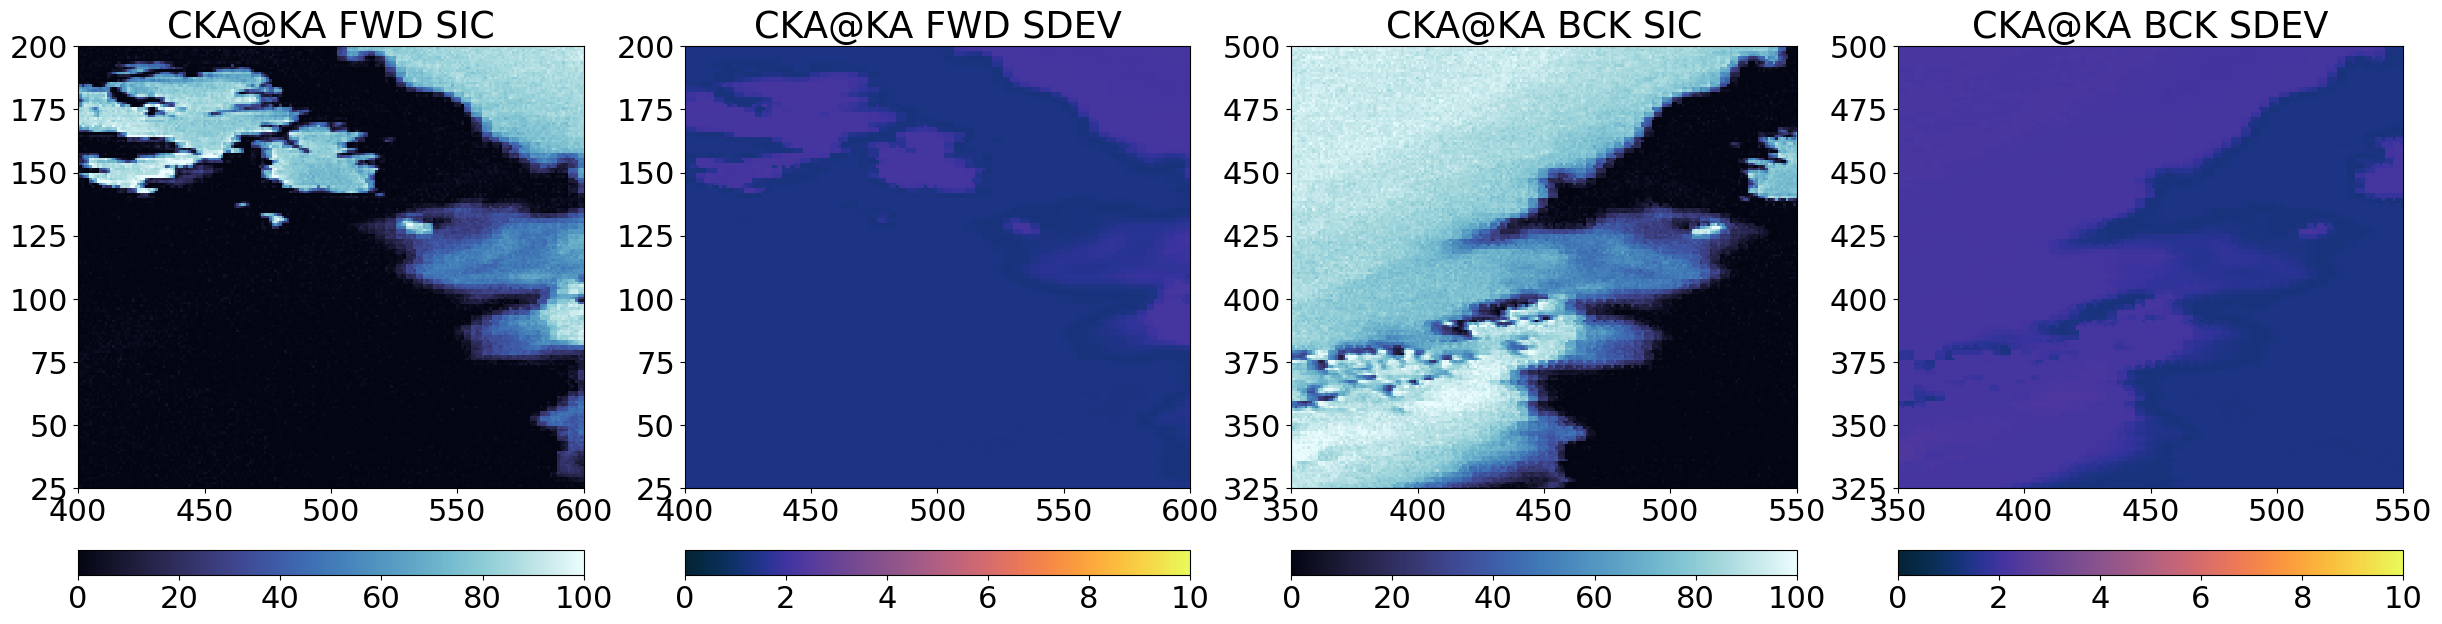

In [21]:
# Simple visualization in swath L1X geometry
for alg in (algo + '(bAs)', sharpener, algo + '(blur)', algo + '(delta)', algo):
    cmap = cmocean.cm.ice
    ucmap = cmocean.cm.thermal
    vmin, vmax = (0, 100)
    umin, umax = (0, 10)
    if 'delta' in alg:
        cmap = cmocean.cm.balance
        ucmap = cmap
        vmin, vmax = (-30, 30)
        umin, umax = (vmin, vmax)
    fig = plt.figure(figsize=(30,16))
    axF = fig.add_subplot(1,4,1)
    cF = axF.imshow(100*for_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axF.set_title(alg + " " + "FWD" + " " + "SIC")
    plt.colorbar(cF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,2, sharex=axF, sharey=axF)
    uF = ax.imshow(for_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "FWD" + " " + "SDEV")
    plt.colorbar(uF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    axB = fig.add_subplot(1,4,3)
    cB = axB.imshow(100*aft_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axB.set_title(alg + " " + "BCK" + " " + "SIC")
    plt.colorbar(cB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,4, sharex=axB, sharey=axB)
    uB=ax.imshow(aft_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "BCK" + " " + "SDEV")
    plt.colorbar(uB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    
    axF.set_xlim(400,600)
    axF.set_ylim(25,200)
    axB.set_xlim(350,550)
    axB.set_ylim(325,500)
    
    plt.show()

These details of the `CKA@KA` results (and intermediate fields) demonstrate that the pan-sharpening algorithm is able to increase the spatial resolution (level of details) in the SIC field (compare first and last rows), and at the same time reduce the retrieval uncertainty (compare the second and last row) that was present in the `KA` results.

We note that the resulting `CKA@KA` results exhibit some 'blockiness' patters along the sea-ice edge. These probably arise from the rather crude way we (temporarily) regrid the `CKA` results to the `KA` grid using own software. The expectation is that these artefacts will be removed (or strongly reduced) once the pan-sharpening steps involve the CIMR RGB toolbox rather than our own software.

## Step 4 : Combine fore and aft scans

For the time being, we resample the SICs from the fore and the aft scans (separately) to an EASE2 grid, then combine them on the grid. We define a status_flag to record if a particular grid cell is from fore+aft scans, only fore, or only aft.

Note: in this implementation we only regrid to the Northern Polar grid because we know that the simulated L1B orbit of the SCEPS Polar Scene 1 does not extend over the Southern Hemisphere. In general, orbits might cover both hemisphere and we will have to grid each orbit both to an NH and and SH grid.

### Step 4.1 : Load the grid definition from parameter file

This was already done as we imported the L2Grids module. The target grid is the NP (Northern Polar) grid at 3 km spacing.

In [22]:
grid_type = 'NP'
adef = L2Grids.L2_EASE2[grid_type + '_3km']
trg_lon, trg_lat = adef.get_lonlats()
trg_spacing = adef.resolution[0]

print(">>> TARGET GRID")
print("===============")
print(adef)
print(trg_spacing)

>>> TARGET GRID
Area ID: ease2_NP3km
Description: EASE2 Northern Polar Regions and Adjacent Seas 3km grid
Projection: {'datum': 'WGS84', 'lat_0': '90', 'lon_0': '0', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 3600
Number of rows: 3600
Area extent: (-5400000.0, -5400000.0, 5400000.0, 5400000.0)
3000.0


We also load the grid definition file for the SCEPS Polar Scene 1, so that we can visualize its extent on the maps

>>> SCEPS Polar Scene 1 GRID
Area ID: crs
Description: crs
Projection: {'datum': 'WGS84', 'lat_0': '90', 'lon_0': '0', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 1400
Number of rows: 1400
Area extent: (0.0, -100000.0, 1400000.0, -1500000.0)


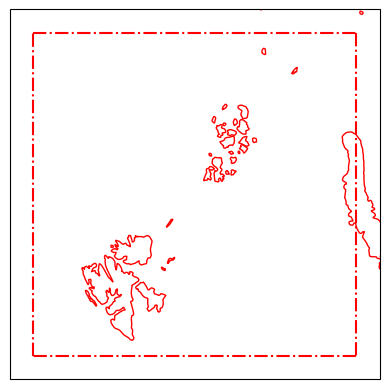

In [23]:
yaml_file = '../data/sceps_polar_scene_1_adef.yaml'
sceps_adef = pr.load_area(yaml_file, 'crs')

print(">>> SCEPS Polar Scene 1 GRID")
print("============================")
print(sceps_adef)

sceps_bbox = sceps_adef.get_bbox_lonlats(vertices_per_side=10,)

def add_sceps_bbox(ax, sceps_bbox):
    for s in range(4):
        _lons = sceps_bbox[0][s]
        _lats = sceps_bbox[1][s]
        ax.plot(_lons, _lats, color='r', ls='-.', transform=ccrs.PlateCarree())
        
fig, ax = plt.subplots(subplot_kw=dict(projection=adef.to_cartopy_crs()))
ax.coastlines(color='red')
ax.set_xlim(-100000,1500000)
ax.set_ylim(-1600000,0)
add_sceps_bbox(ax, sceps_bbox)

### Step 4.2 : Grid the fore and aft fields separately

In [24]:
for_grd = dict()
aft_grd = dict()

# SICs to grid
galgs = ('KA', 'KKA', 'CKA', 'CKA@KA')

for galg in galgs:
    print("Grid FWD and BCK fields for {} to {}".format(galg, adef.area_id))
    if '@' in galg:
        geo_n = galg.split('@')[1]
    else:
        geo_n = galg

    # this is the mean spacing of the SIC field, which is about 4 km for KA and K and 10 km for CKA
    src_spacing = 4000
    if galg == 'CKA':
        src_spacing = 10000

    # extract source geometries (those of the 'sharpener' field)
    for_src_lon = for_geo[geo_n]['lon']
    for_src_lat = for_geo[geo_n]['lat']
    aft_src_lon = aft_geo[geo_n]['lon']
    aft_src_lat = aft_geo[geo_n]['lat']

    # Prepare a stack of the data to be regridded (SIC and sdev)
    what = ('sic','sdev','owf')
    for_stack_shape = tuple(list(for_src_lat.shape) + [len(what),])
    aft_stack_shape = tuple(list(aft_src_lat.shape) + [len(what),])
    for_src_stack = np.empty(for_stack_shape)
    aft_src_stack = np.empty(aft_stack_shape)
    for iw, w in enumerate(what):
        for_src_stack[...,iw] = for_res[galg].get(w)
        aft_src_stack[...,iw] = aft_res[galg].get(w)

    # regrid to the EASE2 grid
    params = {'method':'gauss', 'sigmas':max(trg_spacing,src_spacing/2.), 'neighbours':8}
    _for_grid = coll._regrid_fields(trg_lon, trg_lat, for_src_lon, for_src_lat, for_src_stack, params=params)
    _aft_grid = coll._regrid_fields(trg_lon, trg_lat, aft_src_lon, aft_src_lat, aft_src_stack, params=params)

    # store in an object
    _grd_zeros = np.zeros_like(trg_lon)
    for_grd[galg] = single_algo.SICAlgoResult(np.ma.masked_invalid(_for_grid[:,:,0]),
                                       np.ma.masked_invalid(_for_grid[:,:,1]),
                                       _grd_zeros,
                                       np.ma.masked_invalid(_for_grid[:,:,2]))
    aft_grd[galg] = single_algo.SICAlgoResult(np.ma.masked_invalid(_aft_grid[:,:,0]),
                                       np.ma.masked_invalid(_aft_grid[:,:,1]),
                                       _grd_zeros,
                                       np.ma.masked_invalid(_aft_grid[:,:,2]))
    

Grid FWD and BCK fields for KA to ease2_NP3km


/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 8 neighbours within 7500.0 m for some data points
  get_neighbour_info(source_geo_def,


Grid FWD and BCK fields for KKA to ease2_NP3km
Grid FWD and BCK fields for CKA to ease2_NP3km


/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 8 neighbours within 12500.0 m for some data points
  get_neighbour_info(source_geo_def,


Grid FWD and BCK fields for CKA@KA to ease2_NP3km


Visualization of the gridded fields. The target grid covers the whole Arctic and Adjacent seas. We focus the visualization on the region of the SCEPS Polar Scene 1, that is around Svalbard and the Barents Sea.

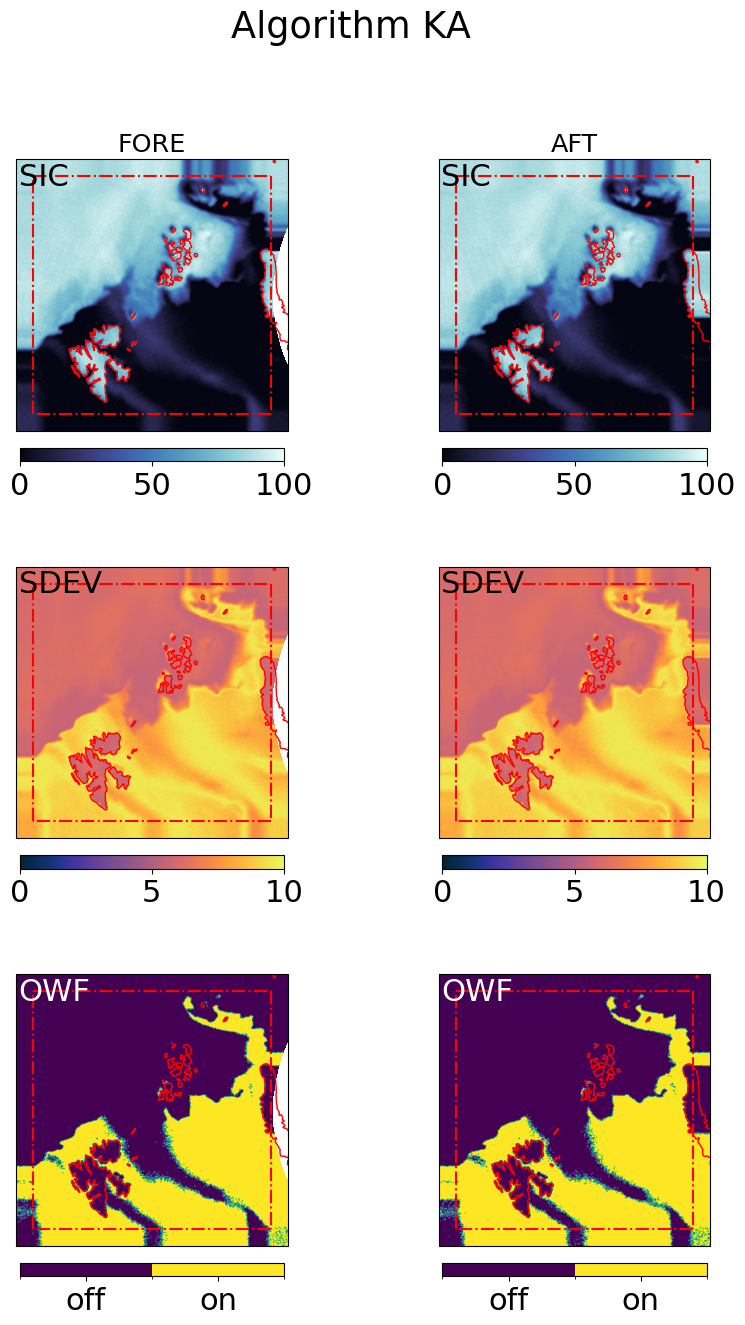

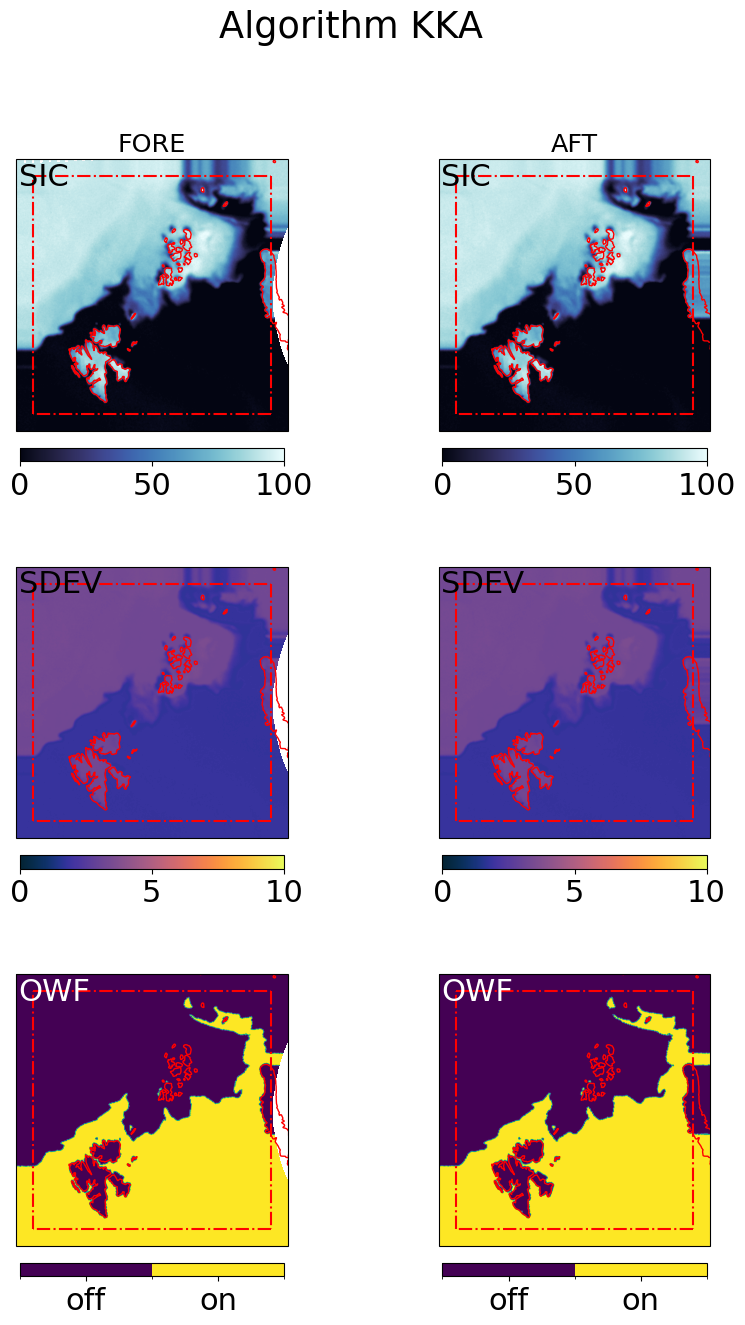

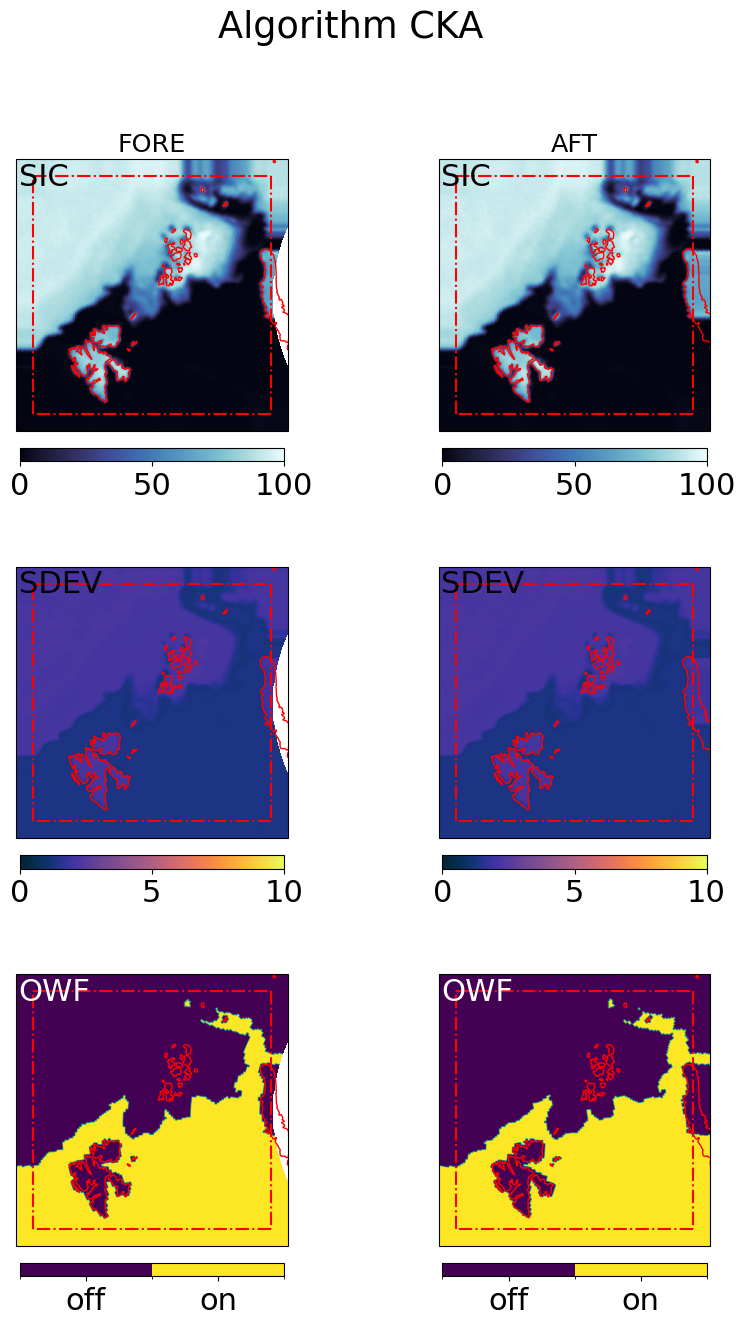

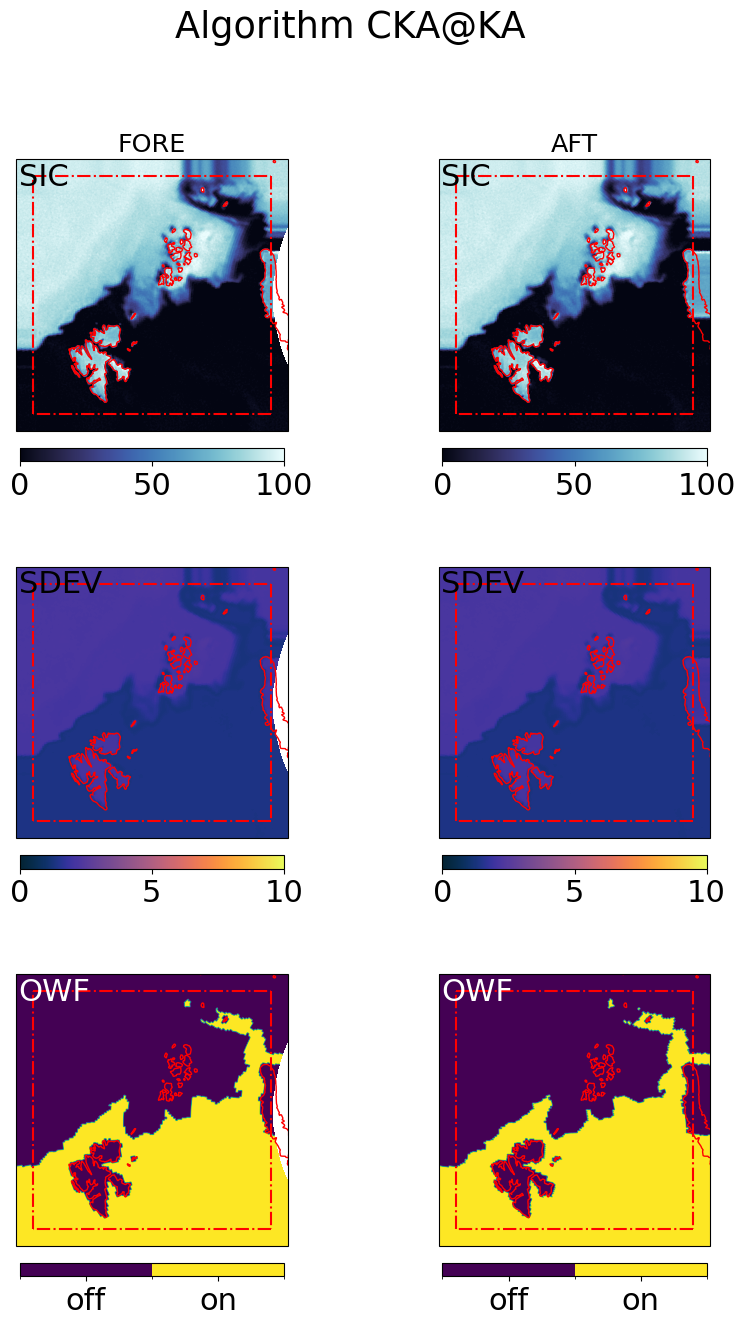

In [25]:
cmap = cmocean.cm.ice
ucmap = cmocean.cm.thermal
ocmap = plt.colormaps.get_cmap('viridis')
vmin, vmax = (0, 100)
umin, umax = (0, 10)
omin, omax = (0, 1)

cart_crs = adef.to_cartopy_crs()

for galg in galgs:

    fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(10,15),
                       subplot_kw=dict(projection=cart_crs))
    
    fig.suptitle("Algorithm {}".format(galg))
    
    # first row : SICs
    c = ax[0,0].imshow(100*for_grd[galg].sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=vmin,vmax=vmax)
    ax[0,0].coastlines(color='red')
    ax[0,0].set_title('FORE', fontsize='small')
    ax[0,0].text(0.01,0.99,'SIC',va='top',transform=ax[0,0].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.75)

    # the target grid covers the whole Arctic, we zoom it around the extent of the SCEPS scene
    ax[0,0].set_xlim(-100000,1500000)
    ax[0,0].set_ylim(-1600000,0)
    add_sceps_bbox(ax[0,0], sceps_bbox)

    c = ax[0,1].imshow(100*aft_grd[galg].sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=vmin,vmax=vmax)
    ax[0,1].coastlines(color='red')
    ax[0,1].set_title('AFT', fontsize='small')
    ax[0,1].text(0.01,0.99,'SIC',va='top',transform=ax[0,1].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.75)
    add_sceps_bbox(ax[0,1], sceps_bbox)

    # second row : SDEVs
    c = ax[1,0].imshow(for_grd[galg].sdev, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ucmap,vmin=umin,vmax=umax)
    ax[1,0].coastlines(color='red')
    ax[1,0].text(0.01,0.99,'SDEV',va='top',transform=ax[1,0].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.75)
    add_sceps_bbox(ax[1,0], sceps_bbox)
    c=ax[1,1].imshow(aft_grd[galg].sdev, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ucmap,vmin=umin,vmax=umax)
    ax[1,1].coastlines(color='red')
    ax[1,1].text(0.01,0.99,'SDEV',va='top',transform=ax[1,1].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.75)
    add_sceps_bbox(ax[1,1], sceps_bbox)

    # second row : OWF
    c = ax[2,0].imshow(for_grd[galg].owf, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ocmap,vmin=omin,vmax=omax)
    cbounds = [-1, 0, 1,]
    cnorm = mpl.colors.BoundaryNorm(cbounds, ocmap.N)
    ax[2,0].coastlines(color='red')
    ax[2,0].text(0.01,0.99,'OWF',va='top',transform=ax[2,0].transAxes, color='w')
    cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=ocmap),orientation='horizontal',
                 pad=0.05, shrink=0.75, ax=ax[2,0])
    cbar.set_ticks([-0.5,0.5,])
    cbar.set_ticklabels(['off', 'on'])
    add_sceps_bbox(ax[2,0], sceps_bbox)
    
    c=ax[2,1].imshow(aft_grd[galg].owf, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ocmap,vmin=omin,vmax=omax)
    ax[2,1].coastlines(color='red')
    ax[2,1].text(0.01,0.99,'OWF',va='top',transform=ax[2,1].transAxes, color='w')
    cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=ocmap),orientation='horizontal',
                      pad=0.05, shrink=0.75, ax=ax[2,1])
    cbar.set_ticks([-0.5,0.5,])
    cbar.set_ticklabels(['off', 'on'])
    add_sceps_bbox(ax[2,1], sceps_bbox)

    
    plt.show()

### Step 4.3 : Combine the fore and aft fields on the grid

At this step, we also perform an analysis step of the merged SIC:
1. We apply the Open Water Filter (OWF) that sets open water targets to exactly 0% SIC;
2. We clip the SICs in the range 0-100% and record the off-range values in a separate variable.

In [26]:
# we call the result, the "merged" sic:
mrg_grd = dict()
mrg_grd_raw = dict()
mrg_grd_flags = dict()


for galg in galgs:

    # have a flag to indicate where the forward and backward scans contributed
    #   "0: no_data, 1: fore_only, 2: aft_only, 3: fore_and_aft"
    mrg_grd_flag = np.zeros(for_grd[galg].sic.shape, dtype='i8')
    _for_valid = ~(for_grd[galg].sic.mask)
    _aft_valid = ~(aft_grd[galg].sic.mask)
    mrg_grd_flag[_for_valid *  _aft_valid] = 3
    mrg_grd_flag[_aft_valid * ~_for_valid] = 2
    mrg_grd_flag[_for_valid * ~_aft_valid] = 1

    # we do a naive merge (arithmetic mean) for now because the uncertainties
    #   in forward and backward fields will be quite similar.
    _mrg_grd_sic = 0.5 * (for_grd[galg].sic + aft_grd[galg].sic)
    _mrg_grd_sic[_for_valid * ~_aft_valid] = for_grd[galg].sic[_for_valid * ~_aft_valid]
    _mrg_grd_sic[_aft_valid * ~_for_valid] = aft_grd[galg].sic[_aft_valid * ~_for_valid]

    # the uncertainties in the forward and backward SIC fields are highly correlated,
    #   thus at the first order the uncertainties are the mean uncertainty (in variance).
    #   This should be revisited e.g. to reduce the uncertainty due to NeDT (which is small
    #   wrt that due to tie-points).
    _mrg_grd_var = 0.5 * (for_grd[galg].sdev**2 + aft_grd[galg].sdev**2)
    _mrg_grd_var[_for_valid * ~_aft_valid] = for_grd[galg].sdev[_for_valid * ~_aft_valid]**2
    _mrg_grd_var[_aft_valid * ~_for_valid] = aft_grd[galg].sdev[_aft_valid * ~_for_valid]**2
    _mrg_grd_sdev = _mrg_grd_var**0.5

    # Combine the OWF with a OR() operator : if one view detected a target as open-water, trust that.
    _mrg_grd_owf = np.zeros(for_grd[galg].sic.shape, dtype='i4')
    _mrg_grd_owf = np.ma.where( (for_grd[galg].owf + aft_grd[galg].owf) >= 1, 1, 0)
    _mrg_grd_owf[_for_valid * ~_aft_valid] = for_grd[algo].owf[_for_valid * ~_aft_valid]
    _mrg_grd_owf[_aft_valid * ~_for_valid] = aft_grd[algo].owf[_aft_valid * ~_for_valid]
    

    # Filter the SIC with the (gridded OWF), and apply the thresholds. 
    print("FILTER AND THRESHOLD THE 'raw' {} SIC:".format(galg))

    _mrg_grd_fsic = _mrg_grd_sic.copy()
    _mrg_grd_fsic[_mrg_grd_owf > 0] = 0.
    _mrg_grd_fsic[_mrg_grd_fsic < 0] = 0.
    _mrg_grd_fsic[_mrg_grd_fsic > 1] = 1.

    print("Range of 'raw' SIC (before filtering and thesholding): [{:.2f}:{:.2f}]".format(
        _mrg_grd_sic.min(), _mrg_grd_sic.max()))
    print("Range of 'filtered' SIC (after filtering and thesholding): [{:.2f}:{:.2f}]".format(
        _mrg_grd_fsic.min(), _mrg_grd_fsic.max()))

    # store in an object (we store the filtered SIC, but keep the raw SIC as well)
    mrg_grd[galg] = single_algo.SICAlgoResult(_mrg_grd_fsic, _mrg_grd_sdev, _grd_zeros, _mrg_grd_owf)
    mrg_grd_flags[galg] = mrg_grd_flag
    mrg_grd_raw[galg] = _mrg_grd_sic

FILTER AND THRESHOLD THE 'raw' KA SIC:
Range of 'raw' SIC (before filtering and thesholding): [-0.25:0.99]
Range of 'filtered' SIC (after filtering and thesholding): [0.00:0.99]
FILTER AND THRESHOLD THE 'raw' KKA SIC:
Range of 'raw' SIC (before filtering and thesholding): [-0.07:1.01]
Range of 'filtered' SIC (after filtering and thesholding): [0.00:1.00]
FILTER AND THRESHOLD THE 'raw' CKA SIC:
Range of 'raw' SIC (before filtering and thesholding): [-0.03:1.00]
Range of 'filtered' SIC (after filtering and thesholding): [0.00:1.00]
FILTER AND THRESHOLD THE 'raw' CKA@KA SIC:
Range of 'raw' SIC (before filtering and thesholding): [-0.26:1.12]
Range of 'filtered' SIC (after filtering and thesholding): [0.00:1.00]


Visualize the merged SICs.

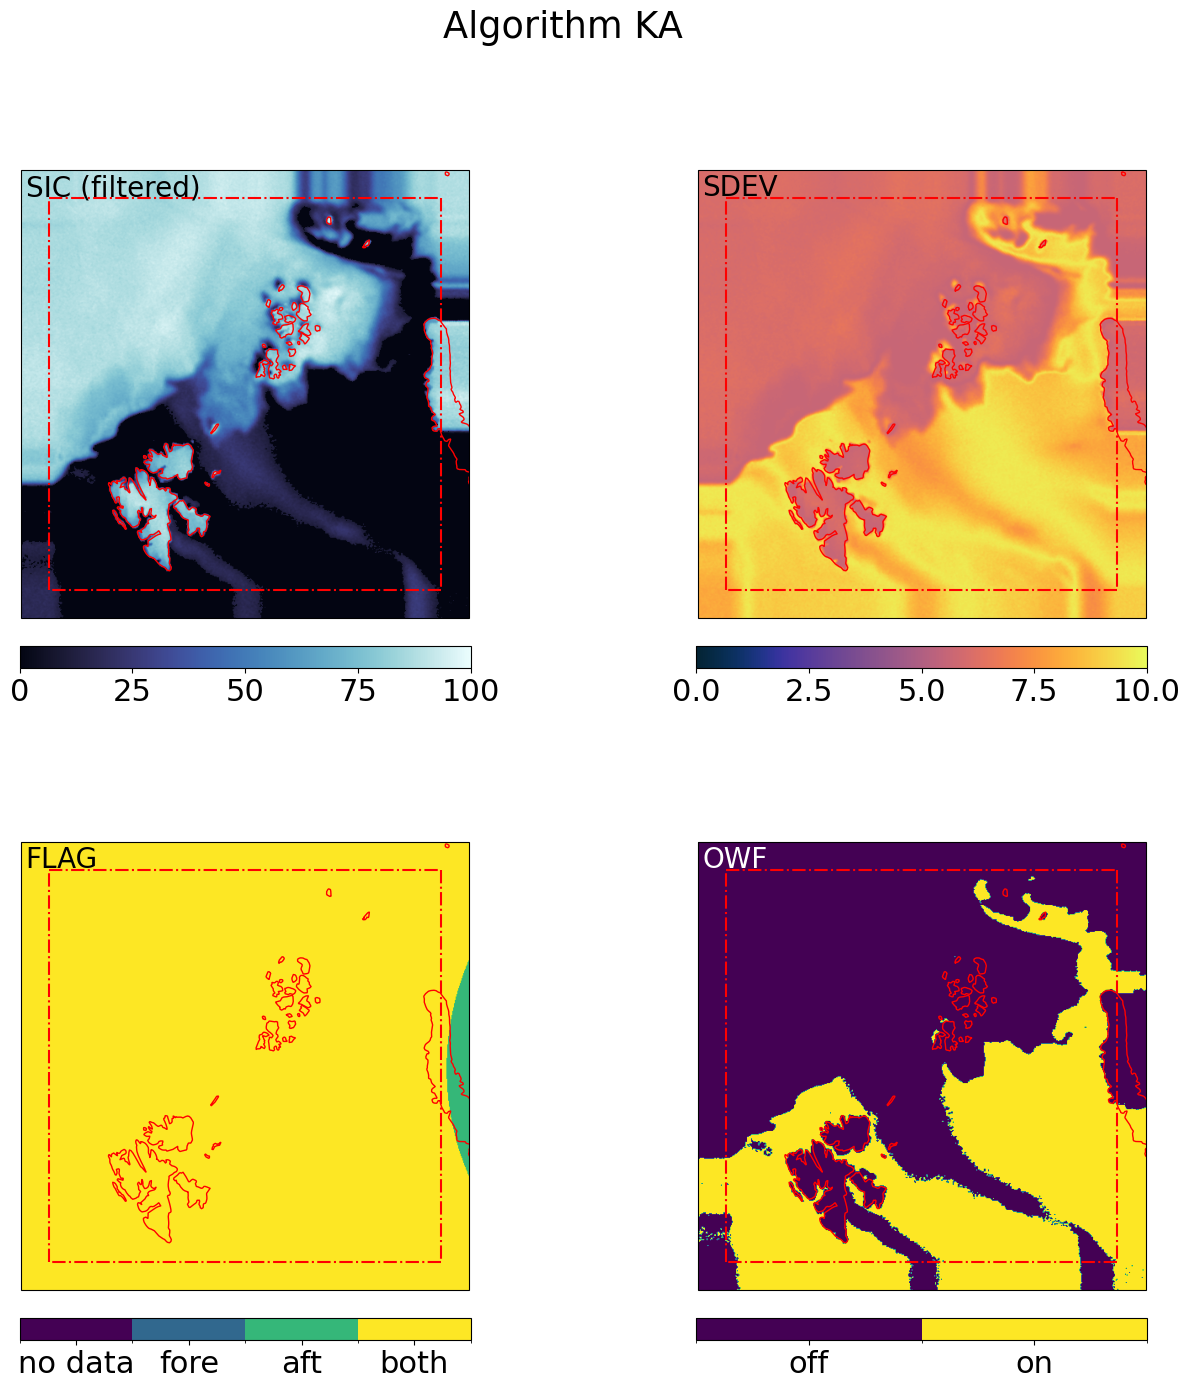

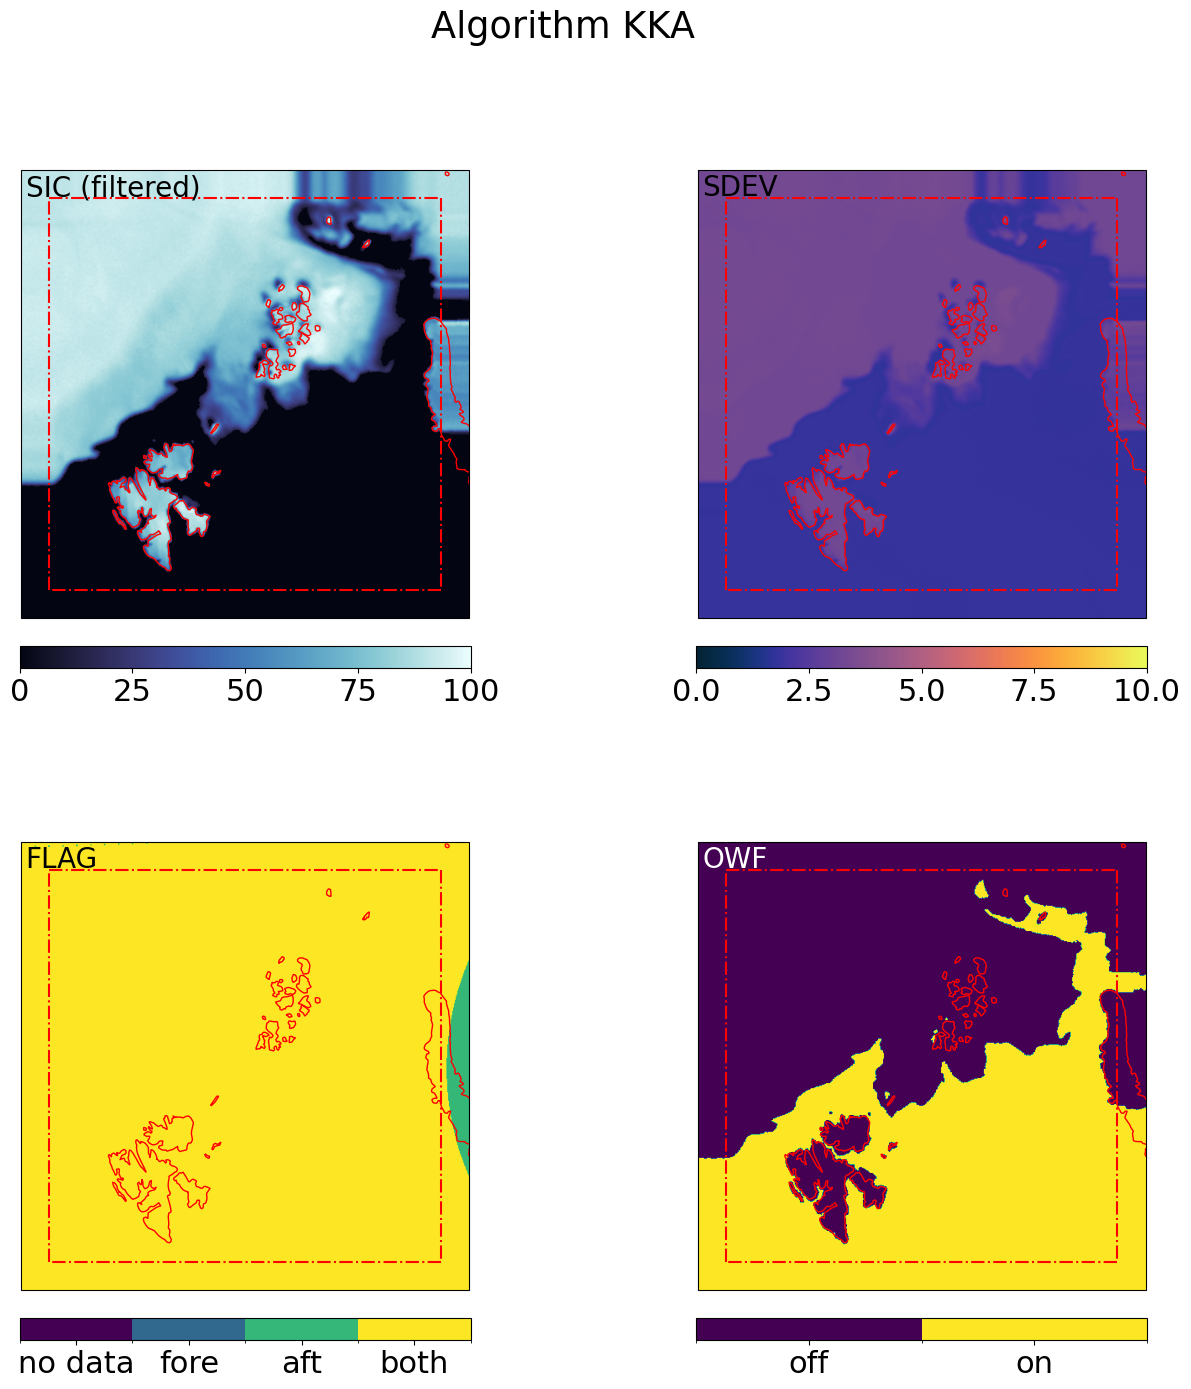

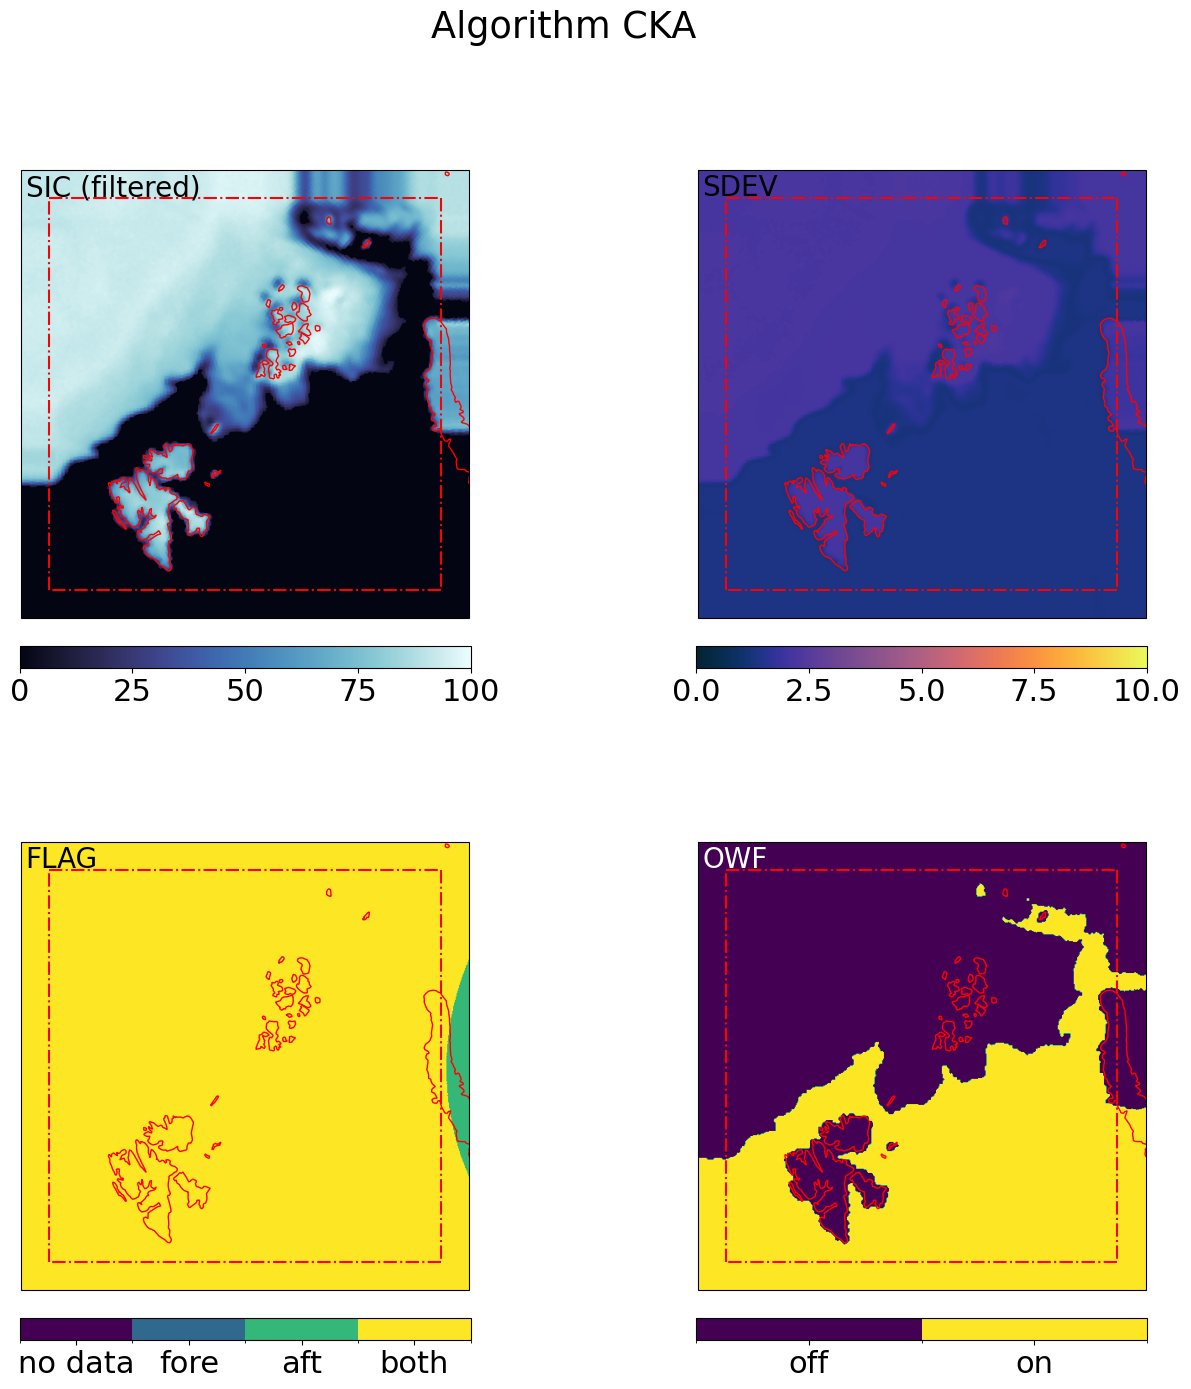

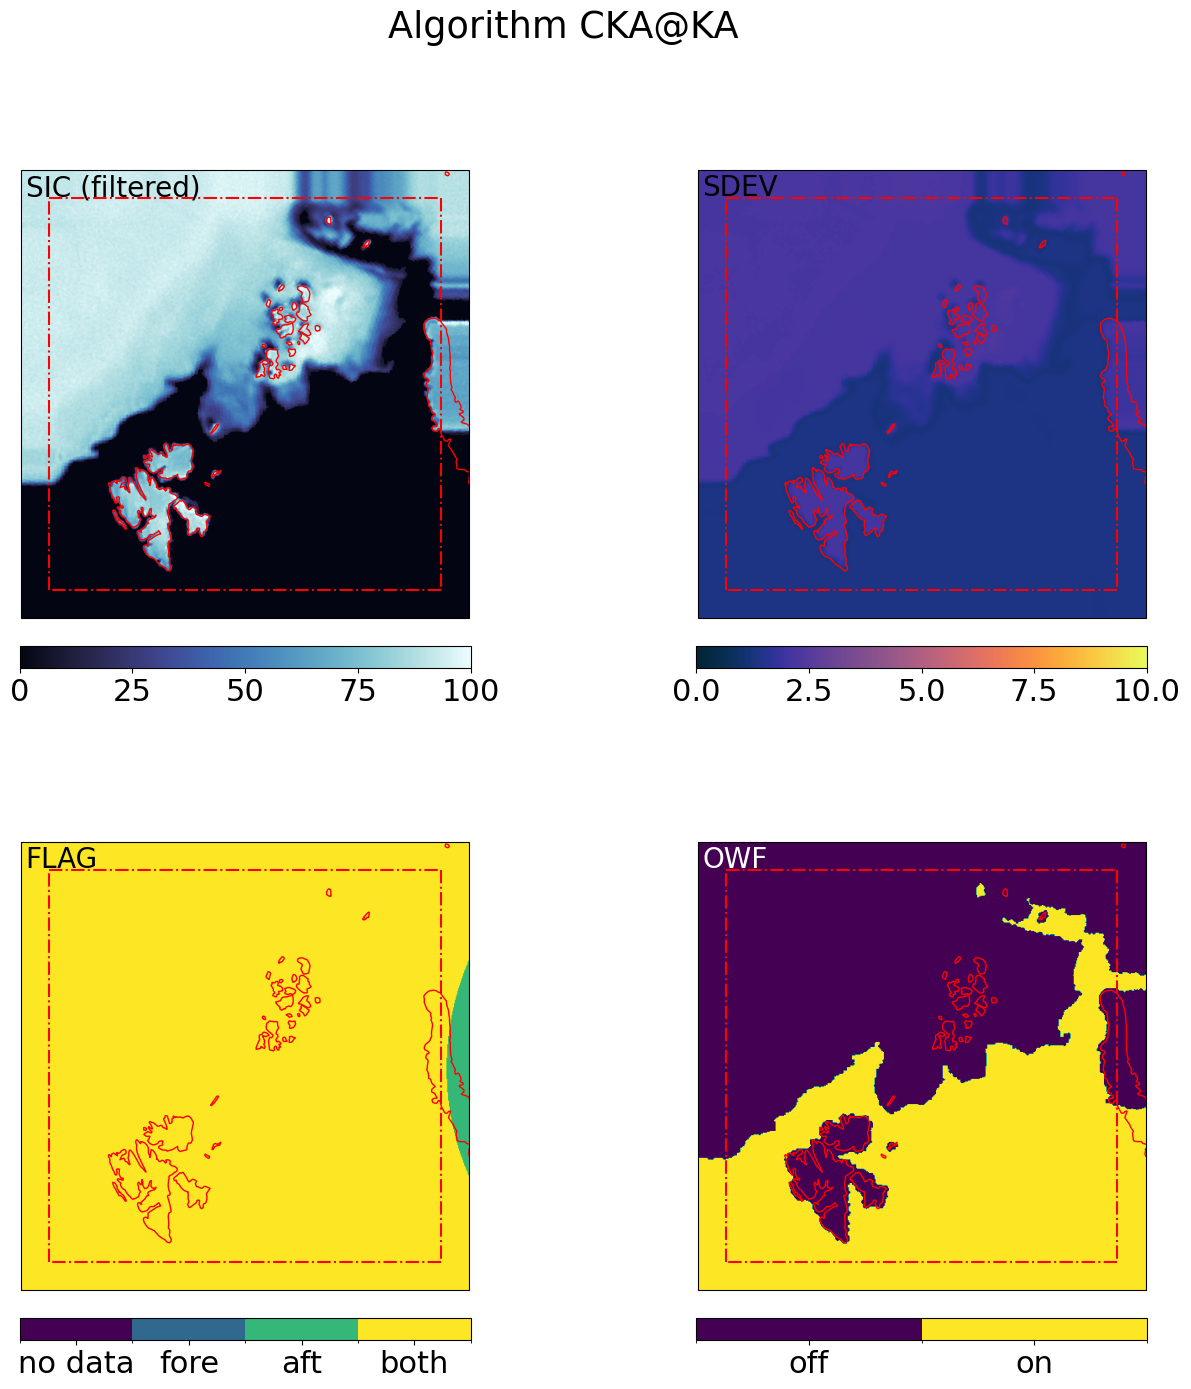

In [27]:
# visualize / plot

for galg in galgs:

    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16,16), subplot_kw=dict(projection=cart_crs))
    fig.suptitle("Algorithm {}".format(galg))
    
    # first : SICs
    c = ax[0,0].imshow(100*mrg_grd[galg].sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=vmin,vmax=vmax)
    ax[0,0].coastlines(color='red')
    ax[0,0].text(0.01,0.99,'SIC (filtered)',va='top',fontsize=20,transform=ax[0,0].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)

    # the target grid covers the whole Arctic, we zoom it around the extent of the SCEPS scene
    ax[0,0].set_xlim(-100000,1500000)
    ax[0,0].set_ylim(-1600000,0)
    add_sceps_bbox(ax[0,0], sceps_bbox)
    
    # second : SDEVs
    c = ax[0,1].imshow(mrg_grd[galg].sdev, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ucmap,vmin=umin,vmax=umax)
    ax[0,1].coastlines(color='red')
    ax[0,1].text(0.01,0.99,'SDEV',va='top',fontsize=20,transform=ax[0,1].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)
    add_sceps_bbox(ax[0,1], sceps_bbox)

    # third : FLAG
    c = ax[1,0].imshow(mrg_grd_flags[galg], transform=cart_crs, extent=cart_crs.bounds, origin='upper',
                       vmin=0, vmax=3, cmap=ocmap)
    cbounds = [0, 1, 2, 3, 4]
    cnorm = mpl.colors.BoundaryNorm(cbounds, ocmap.N)
    ax[1,0].coastlines(color='red')
    ax[1,0].text(0.01,0.99,'FLAG',va='top',fontsize=20,transform=ax[1,0].transAxes,color='k')
    cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=ocmap), orientation='horizontal',
                 pad=0.05, shrink=0.8, ax=ax[1,0])
    cbar.set_ticks([0.5,1.5,2.5,3.5])
    cbar.set_ticklabels(['no data', 'fore', 'aft', 'both'])
    add_sceps_bbox(ax[1,0], sceps_bbox)

    # fourth : OWF
    c = ax[1,1].imshow(mrg_grd[galg].owf, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
                   cmap=ocmap, vmin=omin, vmax=omax)
    cbounds = [-1, 0, 1,]
    cnorm = mpl.colors.BoundaryNorm(cbounds, ocmap.N)
    ax[1,1].coastlines(color='red')
    ax[1,1].text(0.01,0.99,'OWF',va='top',fontsize=20,transform=ax[1,1].transAxes, color='white')
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=ocmap),orientation='horizontal',
                        pad=0.05, shrink=0.8, ax=ax[1,1])
    cbar.set_ticks([-0.5,0.5,])
    cbar.set_ticklabels(['off', 'on'])
    add_sceps_bbox(ax[1,1], sceps_bbox)

    plt.show()

## Step 5: Compute the sea-ice EDGE field

SIED (Sea Ice Edge) is computed from SIC with a simple threshold at SIC = 15%. It is a binary water / ice field.

Importantly, it uses the filtered SIC of CKA@KA as input.

In this version of the algorithm, we process it on the merged gridded output, but it could also be computed at an earlier stage, including in swath projection.



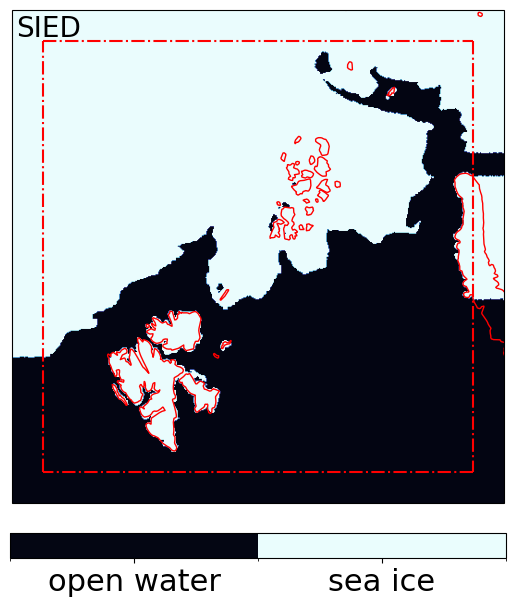

In [28]:
sied_mrg_grd = np.ma.where(mrg_grd['CKA@KA'].sic >= 0.15, 2, 1).astype('byte')

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=cart_crs))
c = ax.imshow(sied_mrg_grd, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=1, vmax=2)
cbounds = [0, 1, 2]
cnorm = mpl.colors.BoundaryNorm(cbounds, cmap.N)

# the target grid covers the whole Arctic, we zoom it around the extent of the SCEPS scene
ax.set_xlim(-100000,1500000)
ax.set_ylim(-1600000,0)
add_sceps_bbox(ax, sceps_bbox)

ax.coastlines(color='red')
ax.text(0.01,0.99,'SIED',va='top',fontsize=20,transform=ax.transAxes)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap),orientation='horizontal', pad=0.05, shrink=0.8,ax=ax)
cbar.set_ticks([0.5,1.5])
cbar.set_ticklabels(['open water', 'sea ice'])
plt.show()

## Step 6: Write Level-2 product file

We write a netCDF/CF files containing the merged SIC on the EASE2 3 km grid. This requires a pre-processing of the SIC fields to apply the Open Water Filter, and have the "raw" SICs into specific variables.

The main SIC is from `CKA@KA`.

Writing the netCDF/CF file is done via xarray. 

In [29]:
# Compute a Timestamp for the L2 product file

# associate a time to this L2 product.
min_l2pp_dt = full_l2pp.data['C']['time_earth'].data.min()
max_l2pp_dt = full_l2pp.data['C']['time_earth'].data.max()

# some simulated files have a wrong units of "days", then we get 'time_earth' as timedelta64.
#   fix for these
if full_l2pp.data['C']['time_earth'].encoding['units'] == 'days':
    print("Correct L1B time (wrong unit in L1B file)")
    min_l2pp_dt += np.datetime64('2000-01-01')
    max_l2pp_dt += np.datetime64('2000-01-01')

# arbitrarily, associate middle time of l1b to l2
l2_dt = min_l2pp_dt + (max_l2pp_dt - min_l2pp_dt) * 0.5
l2_dt = datetime.utcfromtimestamp(l2_dt.astype('int64') / 1e9)
min_l2pp_dt = datetime.utcfromtimestamp(min_l2pp_dt.astype('int64') / 1e9)
max_l2pp_dt = datetime.utcfromtimestamp(max_l2pp_dt.astype('int64') / 1e9)
print("Time for the L2 SIC product: ", l2_dt)

Time for the L2 SIC product:  2028-01-10 11:52:33.075172


In [30]:
# Prepare template file
file_version = '0.1'
latency = 'NRT3H'

fn = L2Filename.build_filename({'DataType':'BRKPT',
                                'ProductString':'SeaIceConcentration', 'AreaID':grid_type,
                                'RepresentativeDateTime':l2_dt.strftime('%Y%m%d%H%M%S'),
                                'FileVersion':file_version}, extra_fields={'Latency':latency})
fn = os.path.join(l2_dir, fn)
    
global_attrs = {'title': 'CIMR L2 Sea Ice Concentration and Edge ({})'.format(latency,),
                    'summary': 'This file holds CIMR Level-2 Sea Ice Concentration and Edge product for the SCEPS Polar Scene 1',
                    'processing_mode': latency,
                    'processor_name': 'CIMR L2PAD SIC',
                    'input_l1b_granule' : os.path.basename(l2pp_path)}
L2Writer.write_netcdf_base(l2_dt, [min_l2pp_dt, max_l2pp_dt], grid_type,
                           xy_dims=('3km',),attrs=global_attrs, filename=fn,)

print("Prepare template file {}".format(fn))

Prepare template file /home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/CIMR-L2PAD-L2-BRKPT-SeaIceConcentration-NP-NRT3H-20280110115233-fv0.1.nc


In [31]:
# Add SeaIceConcentration group and its data layers
def add_sic_group(fn, algo, mrg_grd, mrg_grd_raw, mrg_grd_flag):

    gname = 'SeaIceConcentration'
    if algo != 'CKA@KA':
        gname = gname + algo
    vname = L2Writer.camel_to_snake(gname)

    print("Add {} and its {} variables".format(gname, vname))
    
    L2Writer.add_l2data_subgroup(gname, mrg_grd[algo].sic.astype('float32') * 100, '3km',
                                         {'standard_name':'sea_ice_area_fraction',
                                          'cell_methods':'area:mean where sea',
                                          'units':'%',
                                          'long_name':'Sea Ice Concentration from the {} algorithm, after open-water filtering (OWF) and thresholding were applied.'.format(algo),
                                          'coverage_content_type':'physicalMeasurement',
                                          'auxiliary_variables':'{v:}_uncertainty,{v:}_status_flag'.format(v=vname)
                                         },
                             filename=fn,)
    L2Writer.add_l2data_subgroup(gname, mrg_grd[algo].sdev.astype('float32'), '3km',
                                         {'standard_name':'sea_ice_area_fraction standard_error',
                                          'cell_methods':'area:mean where sea',
                                          'units':'%',
                                          'long_name':'Total Uncertainty for the Sea Ice Concentration from the {} algorithm'.format(algo),
                                          'coverage_content_type':'qualityInformation',
                                         },variable_name_suffix='uncertainty',
                             filename=fn,)
    L2Writer.add_l2data_subgroup(gname, mrg_grd_flag.astype('byte'), '3km',
                                         {'standard_name':'sea_ice_area_fraction status_flag',
                                          'units':'1',
                                          'long_name':'Processing and status flags for the Sea Ice Concentration from the {} algorithm'.format(algo),
                                          'coverage_content_type':'auxiliaryInformation',
                                          'flag_values':np.arange(0,4).astype('byte'),
                                          'flag_meanings':' '.join(['no_data', 'fore_only', 'aft_only', 'fore_and_aft'])
                                         },variable_name_suffix='status_flag',
                             filename=fn,)
    L2Writer.add_l2data_subgroup(gname, mrg_grd_raw[algo].astype('float32') * 100, '3km',
                                         {'standard_name':'sea_ice_area_fraction',
                                          'cell_methods':'area:mean where sea',
                                          'units':'%',
                                          'long_name':'Raw sea-ice Concentration from the {} algorithm, without OWF nor thresholding'.format(algo),
                                          'coverage_content_type':'physicalMeasurement',
                                          'auxiliary_variables':'{v:}_uncertainty,{v:}_status_flag'.format(v=vname)
                                         },variable_name_suffix='raw',
                             filename=fn,)

for alg in ('CKA@KA', 'CKA', 'KKA', 'KA'):
    add_sic_group(fn, alg, mrg_grd, mrg_grd_raw, mrg_grd_flag)

Add SeaIceConcentration and its sea_ice_concentration variables
Add SeaIceConcentrationCKA and its sea_ice_concentration_cka variables
Add SeaIceConcentrationKKA and its sea_ice_concentration_kka variables
Add SeaIceConcentrationKA and its sea_ice_concentration_ka variables


In [32]:
# Add sea-ice edge
gname = 'SeaIceEdge'
vname = L2Writer.camel_to_snake(gname)
print("Add {} and its {} variables".format(gname, vname))
    
L2Writer.add_l2data_subgroup(gname, sied_mrg_grd, '3km',
                             {'standard_name':'sea_ice_classification',
                              'units':'1',
                              'long_name':'Sea-ice edge classification field, based on the CKA@KA SIC',
                              'coverage_content_type':'physicalMeasurement',
                              'auxiliary_variables':'{v:}_status_flag'.format(v=vname),
                              'flag_values': np.array([1, 2], dtype=sied_mrg_grd.dtype),
                              'flag_meanings':'open_water sea_ice',
                              'comment':'The classification is defined by a threshold (15%) on sea ice concentation'
                             },
                             filename=fn,)

L2Writer.add_l2data_subgroup(gname, mrg_grd_flag.astype('byte'), '3km',
                                        {'standard_name':'sea_ice_classification status_flag',
                                          'units':'1',
                                          'long_name':'Processing and status flags for the Sea Ice Edge variable',
                                          'coverage_content_type':'auxiliaryInformation',
                                          'flag_values':np.arange(0,4).astype('byte'),
                                          'flag_meanings':' '.join(['no_data', 'fore_only', 'aft_only', 'fore_and_aft'])
                                         },variable_name_suffix='status_flag',
                             filename=fn,)

print(fn + ' is ready.')

Add SeaIceEdge and its sea_ice_edge variables
/home/thomasl/Work/L2PAD/SeaIceConcentrationEdge_ATBD/data/output/DD-JNB_out/CIMR-L2PAD-L2-BRKPT-SeaIceConcentration-NP-NRT3H-20280110115233-fv0.1.nc is ready.
